## Import Libraries
- numpy
- kmodes (download kmodes library)
- pandas
- ast
- matplotlib
- seaborn

In [1]:
%pip install kmodes --quiet
%pip install gower --quiet
%pip install optuna --quiet
%pip install gower validclust --quiet
%pip install scikit-learn-extra --quiet
%pip install plotly --quiet


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
from kmodes.kprototypes import KPrototypes
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import shap
from sklearn.tree import DecisionTreeClassifier, export_text
import pandas as pd
import gower
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
import optuna
from sklearn.metrics import silhouette_score, davies_bouldin_score
from validclust import dunn
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [3]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message=".*datetime.datetime.utcnow.*"
)


## Load Data
Dataset of all NDRMMC tropical cyclone records from 2021-2025


https://raw.githubusercontent.com/hirajya/K-Prototypes-Clustering-Algorithm-for-Post-Tropical-Cyclone-Impact-Profiling-in-the-Philippines/refs/heads/main/tropical_cyclones_records.csv

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/hirajya/K-Prototypes-Clustering-Algorithm-for-Post-Tropical-Cyclone-Impact-Profiling-in-the-Philippines/refs/heads/main/tropical_cyclones_records.csv')
df.head()

Typhoon Name  Year Region Province City/Municipality  Families   Person  \
0       AGATON  2022      8    LEYTE            ABUYOG   18957.0  68354.0   
1       AGATON  2022      6   ILOILO              AJUY   17414.0  61983.0   
2       AGATON  2022      8    LEYTE        ALANGALANG    1323.0   5444.0   
3       AGATON  2022      8    LEYTE           ALBUERA     203.0   1008.0   
4       AGATON  2022      6   ILOILO         ALIMODIAN       0.0      0.0   

   Brgy  Dead  Injured/Ill  Missing  Totally  Partially   Total  Quantity  \
0  63.0  55.0          0.0      0.0    142.0      326.0   468.0   22690.0   
1  34.0   1.0          0.0      0.0    236.0      856.0  1092.0    4800.0   
2   4.0   NaN          NaN      NaN      NaN        NaN     NaN     228.0   
3   0.0   NaN          NaN      NaN      5.0        0.0     5.0       NaN   
4   0.0   NaN          NaN      NaN      NaN        NaN     NaN       NaN   

          Cost                                               Type  \
0  13172269.32  ['BLANKET', 'BUTANE GAS STOVE', 'CANISTER', 'F...   
1      2948690  ['FAMILY FOOD PACK', 'FINANCIAL', 'HYGIENE KIT...   
2        46740                               ['FAMILY FOOD PACK']   
3          NaN                                                NaN   
4          NaN                                                NaN   

                                            Category  
0  ['FAMILY FOOD PACK', 'HYGIENE KIT', 'KITCHEN K...  
1  ['FAMILY FOOD PACK', 'FINANCIAL / SOCIAL ASSIS...  
2                               ['FAMILY FOOD PACK']  
3                                                NaN  
4                                                NaN

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9228 entries, 0 to 9227
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Typhoon Name       9228 non-null   object 
 1   Year               9228 non-null   int64  
 2   Region             9228 non-null   object 
 3   Province           9228 non-null   object 
 4   City/Municipality  9206 non-null   object 
 5   Families           8704 non-null   float64
 6   Person             8704 non-null   float64
 7   Brgy               8704 non-null   float64
 8   Dead               507 non-null    float64
 9   Injured/Ill        507 non-null    float64
 10  Missing            507 non-null    float64
 11  Totally            3815 non-null   float64
 12  Partially          3815 non-null   float64
 13  Total              3815 non-null   float64
 14  Quantity           3638 non-null   float64
 15  Cost               3769 non-null   object 
 16  Type               3523 

## Data Preprocessing

### 1.1 Standardization of data

Fix column names for consistency and readability & convert all of them to lowercase snakecase




In [6]:
df.rename(columns={'Category': 'Category_Aid'}, inplace=True)


In [7]:
df.columns = df.columns.str.lower().str.replace('/', '_').str.replace(' ', '_')

print("Columns now:", list(df.columns))

Columns now: ['typhoon_name', 'year', 'region', 'province', 'city_municipality', 'families', 'person', 'brgy', 'dead', 'injured_ill', 'missing', 'totally', 'partially', 'total', 'quantity', 'cost', 'type', 'category_aid']


In [8]:
df['cost'] = pd.to_numeric(df['cost'], errors='coerce')

Remove unnecessary columns
- type (baseline simplication basis of category)
- quantity (inconsistent values, same depth across all aids, not realiable)

In [9]:
df.drop(['type', 'quantity'], axis=1, inplace=True)

### 1.2 Handling Categorical & Impact Missing Values
Print the NaN/null values



In [10]:
df.isnull().sum()

typhoon_name            0
year                    0
region                  0
province                0
city_municipality      22
families              524
person                524
brgy                  524
dead                 8721
injured_ill          8721
missing              8721
totally              5413
partially            5413
total                5413
cost                 5462
category_aid         5714
dtype: int64

category -> replace NaN with ```['NOT SPECIFIED]```'

In [11]:
df['category_aid'] = df['category_aid'].fillna("['NOT SPECIFIED']")

city_municipality -> replace NaN with ```'UNKNOWN'```

In [12]:
df['city_municipality'] = df['city_municipality'].fillna('UNKNOWN')

impact-related columns ```(families, brgy, dead, injured_ill, missing, totally, partially, total)``` replace NaN with 0

In [13]:
zero_fill_cols = [
    'families', 'person', 'brgy',
    'dead', 'injured_ill', 'missing',
    'totally', 'partially', 'total'
]

df[zero_fill_cols] = df[zero_fill_cols].fillna(0)

In [14]:
# Count rows where 'person' is 0
zero_person_count = df[df['person'] == 0].shape[0]
print(f"Number of rows with 0 persons: {zero_person_count}")

# Remove rows where 'person' is 0
df = df[df['person'] > 0].copy()
print(f"Remaining rows after removal: {df.shape[0]}")

Number of rows with 0 persons: 980
Remaining rows after removal: 8248


In [15]:
for col in ['region', 'province', 'city_municipality']:
    df[col] = df[col].str.upper()

### 1.3 Verification Tagging
Events are tagged as either verified or unverified by the means of data

parse category column string to list

In [16]:
def parse_category(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else [x]
    except:
        return  ['NOT SPECIFIED']

df['category_aid'] = df['category_aid'].apply(parse_category)


**Verified events:** contain significant values in key columns (e.g. families, person, cost)

**Unverified events:** lacks significant values and having a unspecified categories (categories that equals to ```['NOT SPECIFIED']```, ```['NO BREAKDOWN']```, ```['FOR VERIFCATION']```)

In [17]:
category_counts = df['category_aid'].explode().value_counts()
print(category_counts)

category_aid
NOT SPECIFIED                            5194
FAMILY FOOD PACK                         2284
FINANCIAL / SOCIAL ASSISTANCE             670
OTHERS                                    602
HYGIENE KIT                               354
SLEEPING KIT                              288
NO BREAKDOWN                              169
KITCHEN KIT                               166
SHELTER KIT                               109
READY TO EAT FOOD                         105
FOR VERIFICATION                          103
CLOTHING KIT                               73
LOGISTICAL SUPPORT                         22
MEDICAL                                     6
READY TO EAT FOOD, LOGISTICAL SUPPORT       1
LIVELIHOOD                                  1
READY TO EAT FOOD, CLOTHING KIT             1
Name: count, dtype: int64


In [18]:
unverified_mask = df['category_aid'].apply(
    lambda x: any(item in ['NOT SPECIFIED', 'NO BREAKDOWN', 'FOR VERIFICATION'] for item in x)
)

In [19]:
unverified_mask.value_counts()

category_aid
True     5466
False    2782
Name: count, dtype: int64

### 1.4 Handling Missing Data using Unverified Masked

cost -> replace NaN with median cost (from tagged verified records only)

In [20]:
valid_cost_mask = ~unverified_mask & df['cost'].notna()
cost_median = df[valid_cost_mask]['cost'].median()

df.loc[~unverified_mask & df['cost'].isna(), 'cost'] = cost_median
df['cost'] = df['cost'].fillna(0) # final fallback

### 1.5 Simplication Mapping and Encoding of Category

*   Simplify and consolidate raw categories into fewer, more meaningful groups
*   Apply one-hot encoding to thematic varaibles for downstream analysis



In [21]:
def clean_and_split(lst):
    cleaned = []
    for item in lst:
        item = str(item).strip()
        # Handle combined: "READY TO EAT FOOD, CLOTHING KIT"
        if ',' in item and any(k in item for k in ['KIT', 'FOOD']):
            parts = [p.strip() for p in item.split(',') if p.strip()]
            cleaned.extend(parts)
        else:
            cleaned.append(item)
    return [c for c in cleaned if c not in ['', 'UNVERIFIED']]

# apply
df['category_aid'] = df['category_aid'].apply(clean_and_split)

In [22]:
# Mapping for normalization
mapping = {
    'NOT SPECIFIED': 'UNVERIFIED',
    'NO BREAKDOWN': 'UNVERIFIED',
    'FOR VERIFICATION': 'UNVERIFIED',
    'READY TO EAT FOOD': 'READY-TO-EAT MEALS',
    'CLOTHING KIT': 'CLOTHING',
    'LOGISTICAL SUPPORT': 'LOGISTICS',
    'MEDICAL': 'MEDICAL ASSISTANCE',
    'OTHERS': 'OTHER / UNSPECIFIED'
}

def standardize(item):
    return mapping.get(item.upper(), item.upper())  # normalize via mapping

def get_themes(items):
    themes = set()
    for item in items:
        item = standardize(item)
        if any(k in item for k in ['FAMILY FOOD PACK', 'READY-TO-EAT MEALS']):
            themes.add('Food')
        elif 'FINANCIAL' in item or 'SOCIAL ASSISTANCE' in item:
            themes.add('Cash')
        elif 'HYGIENE KIT' in item or 'MEDICAL ASSISTANCE' in item:
            themes.add('Hygiene & Health')
        elif 'SLEEPING KIT' in item or 'KITCHEN KIT' in item:
            themes.add('Sleeping Essentials')
        elif 'SHELTER KIT' in item or 'CLOTHING' in item or 'TARP' in item:
            themes.add('Shelter Support')
        elif 'LOGISTICS' in item:
            themes.add('Logistics')
        elif 'OTHER / UNSPECIFIED' in item:
            themes.add('Other')
        else:
            themes.add('Unverified')
    return list(themes)

# apply
df['aid_themes'] = df['category_aid'].apply(get_themes)

In [23]:
for theme in ['Food', 'Cash', 'Hygiene & Health', 'Sleeping Essentials', 'Shelter Support']:
    col_name = f'has_{theme.lower().replace(" & ", "_").replace(" ", "_")}'
    df[col_name] = df['aid_themes'].apply(lambda x: 1 if theme in x else 0)

In [24]:
# Show distribution of themes
all_themes = [t for themes in df['aid_themes'] for t in themes]
theme_counts = pd.Series(all_themes).value_counts()
print(theme_counts)

Unverified             5467
Food                   2323
Cash                    670
Other                   602
Hygiene & Health        356
Sleeping Essentials     327
Shelter Support         169
Logistics                23
Name: count, dtype: int64


In [25]:
df.drop(['aid_themes', 'category_aid'], axis=1, inplace=True)

#### See the miscorrect region input

In [26]:
pd.set_option("display.max_rows", None)   # show all rows
pd.set_option("display.max_columns", None)  # show all columns if needed

print(df['region'].value_counts())


region
4A        1042
3         1028
5          991
6          924
1          853
2          701
CAR        601
4B         514
8          490
7          268
BARMM      151
10         150
CARAGA     146
NCR        135
12          74
11          67
9           64
13          49
Name: count, dtype: int64


In [27]:
misamis_oriental_df = df[df['province'] == 'MISAMIS ORIENTAL']


In [28]:
agusan_del_norte_df = df[df['province'] == 'AGUSAN DEL NORTE']


In [29]:
surigao_del_sur_df = df[df['province'] == 'SURIGAO DEL SUR']


In [30]:
surigao_del_norte_df = df[df['province'] == 'SURIGAO DEL NORTE']


In [31]:
negros_oriental_df = df[df['province'] == 'NEGROS ORIENTAL']


In [32]:
df['region'] = df['region'].replace({'13': 'CARAGA'})

df.loc[df['province'] == 'MISAMIS ORIENTAL', 'region'] = '10'
df.loc[df['province'] == 'AGUSAN DEL NORTE', 'region'] = 'CARAGA'
df.loc[df['province'] == 'SURIGAO DEL SUR', 'region'] = 'CARAGA'
df.loc[df['province'] == 'SURIGAO DEL NORTE', 'region'] = 'CARAGA'
df.loc[df['province'] == 'NEGROS ORIENTAL', 'region'] = '7'


In [33]:
import pandas as pd

pd.set_option("display.max_rows", None)   # show all rows
pd.set_option("display.max_columns", None)  # show all columns if needed

print(df['region'].value_counts())


region
4A        1042
3         1028
5          991
6          923
1          853
2          701
CAR        601
4B         514
8          490
7          269
CARAGA     195
10         161
BARMM      151
NCR        135
12          74
11          66
9           54
Name: count, dtype: int64


In [34]:
df.head()

typhoon_name  year region province city_municipality  families   person  \
0       AGATON  2022      8    LEYTE            ABUYOG   18957.0  68354.0   
1       AGATON  2022      6   ILOILO              AJUY   17414.0  61983.0   
2       AGATON  2022      8    LEYTE        ALANGALANG    1323.0   5444.0   
3       AGATON  2022      8    LEYTE           ALBUERA     203.0   1008.0   
5       AGATON  2022      8  BILIRAN           ALMERIA     125.0    488.0   

   brgy  dead  injured_ill  missing  totally  partially   total         cost  \
0  63.0  55.0          0.0      0.0    142.0      326.0   468.0  13172269.32   
1  34.0   1.0          0.0      0.0    236.0      856.0  1092.0   2948690.00   
2   4.0   0.0          0.0      0.0      0.0        0.0     0.0     46740.00   
3   0.0   0.0          0.0      0.0      5.0        0.0     5.0         0.00   
5  11.0   0.0          0.0      0.0      0.0        0.0     0.0         0.00   

   has_food  has_cash  has_hygiene_health  has_sleeping_essentials  \
0         1         0                   1                        1   
1         1         1                   1                        1   
2         1         0                   0                        0   
3         0         0                   0                        0   
5         0         0                   0                        0   

   has_shelter_support  
0                    0  
1                    0  
2                    0  
3                    0  
5                    0

## Feature Engineering

### 2.1 Transformation from Event-Based to City-Based Data

*   Create a composite ID = ```(province, region)```

Aggregate data by composite ID:
* Sum ```(families, person, dead, injured_ill, missing, totally, partially, cost)```
* Sum ```(has_food, has_cash, has_hygiene_health, has_sleeping_essentials, has_shelter_support)```
* Count Number of typhoon events using nunique
* First and last year for recurrence rate, year min max







In [35]:
# --- Step 1. Clean and prepare typhoon names ---
df['typhoon_name_clean'] = df['typhoon_name'].str.strip()

# Create exploded version for individual typhoons
df['typhoon_list'] = df['typhoon_name_clean'].str.split('-')
df_exploded = df.explode('typhoon_list')
df_exploded['typhoon_list'] = df_exploded['typhoon_list'].str.strip()

# --- Step 2. Aggregation dictionary (impact + aid only, no typhoon count here) ---
agg_dict = {
    # Impact & Damage (sum)
    'families': 'sum',
    'person': 'sum',
    'dead': 'sum',
    'injured_ill': 'sum',
    'missing': 'sum',
    'totally': 'sum',
    'partially': 'sum',
    'cost': 'sum',

    # Aid flags (sum across events)
    'has_food': 'sum',
    'has_cash': 'sum',
    'has_hygiene_health': 'sum',
    'has_sleeping_essentials': 'sum',
    'has_shelter_support': 'sum',

    # First and last year for recurrence rate
    'year': ['min', 'max'],
}

# --- Step 3. Aggregate by municipality ---
city_df = (
    df.groupby(['city_municipality', 'province', 'region'])
      .agg(agg_dict)
      .reset_index()
)

# Flatten column names
city_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in city_df.columns]
city_df = city_df.rename(columns={
    'city_municipality': 'city_municipality_',
    'province': 'province_',
    'region': 'region_',
    'year_min': 'first_year',
    'year_max': 'last_year'
})

# --- Step 4. Add num_reports (unique merged names) ---
city_reports = (
    df.groupby(['city_municipality', 'province', 'region'])
      .agg({'typhoon_name_clean': 'nunique'})
      .reset_index()
      .rename(columns={'typhoon_name_clean': 'num_reports'})
)

# --- Step 5. Add num_typhoons (unique exploded names) ---
city_typhoons = (
    df_exploded.groupby(['city_municipality', 'province', 'region'])
               .agg({'typhoon_list': 'nunique'})
               .reset_index()
               .rename(columns={'typhoon_list': 'num_typhoons'})
)

# --- Step 6. Merge into final dataframe ---
city_df = (
    city_df
    .merge(city_reports,
           left_on=['city_municipality_', 'province_', 'region_'],
           right_on=['city_municipality', 'province', 'region'],
           how='left',
           suffixes=('', '_dup1'))
    .merge(city_typhoons,
           left_on=['city_municipality_', 'province_', 'region_'],
           right_on=['city_municipality', 'province', 'region'],
           how='left',
           suffixes=('', '_dup2'))
)

# Drop duplicate key columns created by merge
city_df = city_df.drop(columns=['city_municipality', 'province', 'region'])




In [36]:
city_df

city_municipality_              province_ region_  \
0                         ABORLAN                PALAWAN      4B   
1                    ABRA DE ILOG     OCCIDENTAL MINDORO      4B   
2                          ABUCAY                   ABRA     CAR   
3                          ABUCAY                 BATAAN       3   
4                          ABULUG                CAGAYAN       2   
5                          ABUYOG                  LEYTE       8   
6                           ADAMS           ILOCOS NORTE       1   
7                        AGDANGAN                 QUEZON      4A   
8                         AGLIPAY                QUIRINO       2   
9                            AGNO             PANGASINAN       1   
10                      AGONCILLO               BATANGAS      4A   
11                           AGOO               LA UNION       1   
12                        AGUILAR             PANGASINAN       1   
13                      AGUINALDO                 IFUGAO     CAR   
14                        AGUTAYA                PALAWAN      4B   
15                           AJUY                 ILOILO       6   
16                         ALABAT                 QUEZON      4A   
17                         ALABEL              SARANGANI      12   
18                        ALAMADA               COTABATO      12   
19                       ALAMINOS                 LAGUNA      4A   
20                       ALAMINOS             PANGASINAN       1   
21                     ALANGALANG                  LEYTE       8   
22                        ALBUERA                  LEYTE       8   
23                   ALBURQUERQUE                  BOHOL       7   
24                         ALCALA                CAGAYAN       2   
25                         ALCALA             PANGASINAN       1   
26                      ALCANTARA                   CEBU       7   
27                      ALCANTARA                ROMBLON      4B   
28                          ALCOY                   CEBU       7   
29                        ALEGRIA                   CEBU       7   
30                        ALEGRIA      SURIGAO DEL NORTE  CARAGA   
31                        ALEOSAN               COTABATO      12   
32                        ALFONSO                 CAVITE      4A   
33              ALFONSO CASTAÑEDA          NUEVA VIZCAYA       2   
34                  ALFONSO LISTA                 IFUGAO     CAR   
35                         ALIAGA            NUEVA ECIJA       3   
36                         ALICIA                  BOHOL       7   
37                         ALICIA                ISABELA       2   
38                         ALILEM             ILOCOS SUR       1   
39                      ALIMODIAN                 ILOILO       6   
40                      ALITAGTAG               BATANGAS      4A   
41                      ALLACAPAN                CAGAYAN       2   
42                          ALLEN         NORTHERN SAMAR       8   
43                        ALMAGRO                  SAMAR       8   
44                        ALMERIA                BILIRAN       8   
45                     ALOGUINSAN                   CEBU       7   
46                         ALORAN     MISAMIS OCCIDENTAL      10   
47                        ALTAVAS                  AKLAN       6   
48                       ALUBIJID       MISAMIS ORIENTAL      10   
49                         AMADEO                 CAVITE      4A   
50                       AMBAGUIO          NUEVA VIZCAYA       2   
51                          AMLAN        NEGROS ORIENTAL       7   
52                       AMPATUAN            MAGUINDANAO   BARMM   
53                       AMPATUAN    MAGUINDANAO DEL SUR   BARMM   
54                        AMULUNG                CAGAYAN       2   
55                       ANAHAWAN         SOUTHERN LEYTE       8   
56                           ANAO                 TARLAC       3   
57                           ANDA                  BOHOL       7   
58 

### 2.2 Derived Features

*   new column for ```recurrence_rate``` = num of typhoons / (last year - first year + 1)
*   new column for ```cost_per_family``` = cost_sum / families_sum[link text](https://)



In [37]:
city_df['recurrence_rate'] = city_df['num_typhoons'] / (
    city_df['last_year'] - city_df['first_year'] + 1
)

In [38]:
city_df['cost_per_family'] = city_df.apply(
    lambda row: row['cost_sum'] / row['families_sum'] if row['families_sum'] > 0 else np.nan,
    axis=1
)

In [39]:
city_df.isnull().sum()

city_municipality_             0
province_                      0
region_                        0
families_sum                   0
person_sum                     0
dead_sum                       0
injured_ill_sum                0
missing_sum                    0
totally_sum                    0
partially_sum                  0
cost_sum                       0
has_food_sum                   0
has_cash_sum                   0
has_hygiene_health_sum         0
has_sleeping_essentials_sum    0
has_shelter_support_sum        0
first_year                     0
last_year                      0
num_reports                    0
city_municipality_dup2         0
province_dup2                  0
region_dup2                    0
num_typhoons                   0
recurrence_rate                0
cost_per_family                0
dtype: int64

## Feature Selection
Building correlation matrix and removing
```families_sum, first_year, last_year, total```

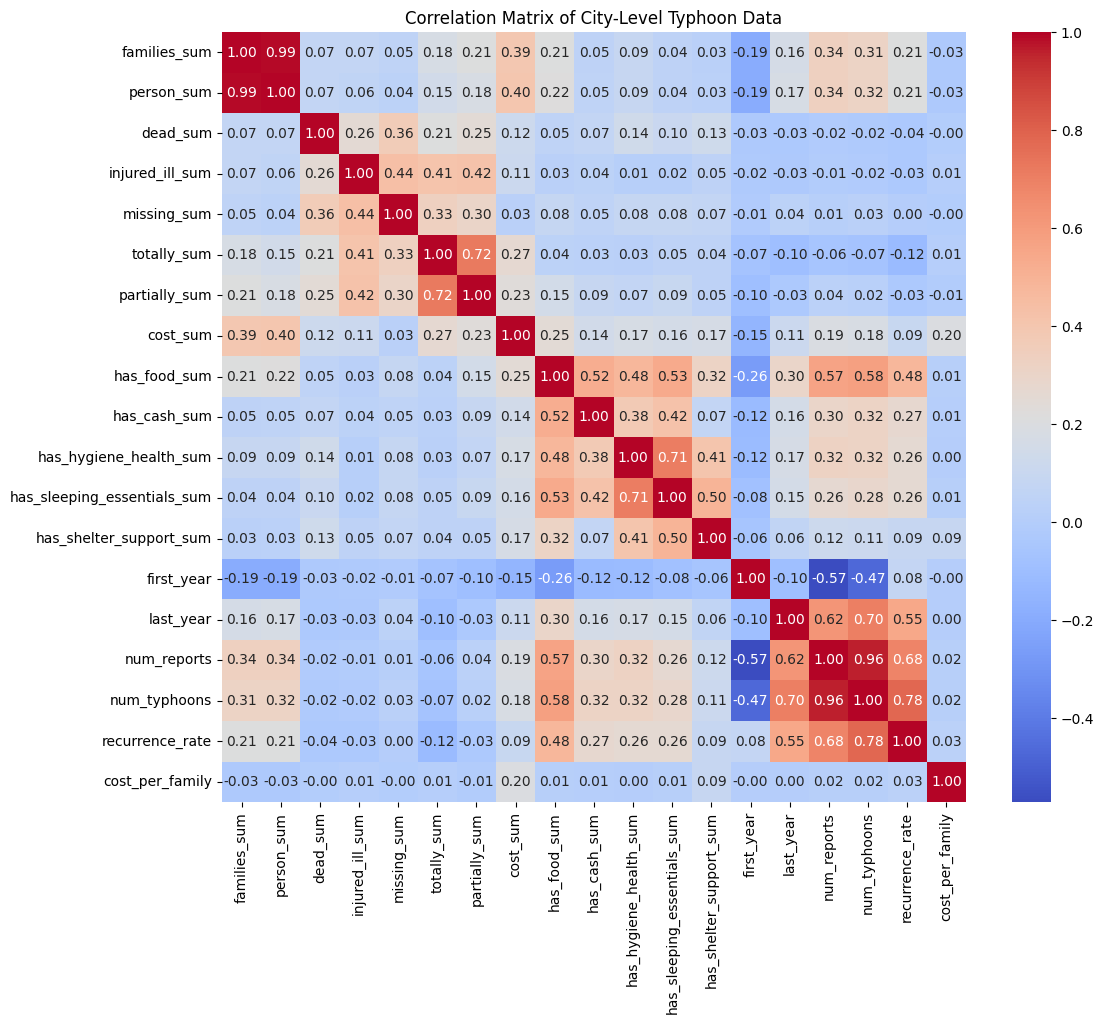

In [40]:
correlation_matrix = city_df.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of City-Level Typhoon Data')
plt.show()

In [41]:
standard_df = city_df.copy()

In [42]:
city_df.drop(['families_sum', 'first_year', 'last_year', 'num_reports', 'city_municipality_dup2', 'province_dup2', 'region_dup2'], axis=1, inplace=True)


#### Changing the index to province + region

In [43]:
# Create a unique province-region ID
city_df['city_province_region'] = city_df['city_municipality_'] + ' - '+ city_df['province_']  +' (' + city_df['region_'] + ')'

# Set it as index (optional but clean)
city_df.set_index('city_province_region', inplace=True)

# Now drop the original 'province_' column
city_df.drop(columns=['city_municipality_'], inplace=True)

In [44]:
city_df.columns

Index(['province_', 'region_', 'person_sum', 'dead_sum', 'injured_ill_sum',
       'missing_sum', 'totally_sum', 'partially_sum', 'cost_sum',
       'has_food_sum', 'has_cash_sum', 'has_hygiene_health_sum',
       'has_sleeping_essentials_sum', 'has_shelter_support_sum',
       'num_typhoons', 'recurrence_rate', 'cost_per_family'],
      dtype='object')

In [45]:
city_df

province_  \
city_province_region                                                        
ABORLAN - PALAWAN (4B)                                            PALAWAN   
ABRA DE ILOG - OCCIDENTAL MINDORO (4B)                 OCCIDENTAL MINDORO   
ABUCAY - ABRA (CAR)                                                  ABRA   
ABUCAY - BATAAN (3)                                                BATAAN   
ABULUG - CAGAYAN (2)                                              CAGAYAN   
ABUYOG - LEYTE (8)                                                  LEYTE   
ADAMS - ILOCOS NORTE (1)                                     ILOCOS NORTE   
AGDANGAN - QUEZON (4A)                                             QUEZON   
AGLIPAY - QUIRINO (2)                                             QUIRINO   
AGNO - PANGASINAN (1)                                          PANGASINAN   
AGONCILLO - BATANGAS (4A)                                        BATANGAS   
AGOO - LA UNION (1)                                              LA UNION   
AGUILAR - PANGASINAN (1)                                       PANGASINAN   
AGUINALDO - IFUGAO (CAR)                                           IFUGAO   
AGUTAYA - PALAWAN (4B)                                            PALAWAN   
AJUY - ILOILO (6)                                                  ILOILO   
ALABAT - QUEZON (4A)                                               QUEZON   
ALABEL - SARANGANI (12)                                         SARANGANI   
ALAMADA - COTABATO (12)                                          COTABATO   
ALAMINOS - LAGUNA (4A)                                             LAGUNA   
ALAMINOS - PANGASINAN (1)                                      PANGASINAN   
ALANGALANG - LEYTE (8)                                              LEYTE   
ALBUERA - LEYTE (8)                                                 LEYTE   
ALBURQUERQUE - BOHOL (7)                                            BOHOL   
ALCALA - CAGAYAN (2)                                              CAGAYAN   
ALCALA - PANGASINAN (1)                                        PANGASINAN   
ALCANTARA - CEBU (7)                                                 CEBU   
ALCANTARA - ROMBLON (4B)                                          ROMBLON   
ALCOY - CEBU (7)                                                     CEBU   
ALEGRIA - CEBU (7)                                                   CEBU   
ALEGRIA - SURIGAO DEL NORTE (CARAGA)                    SURIGAO DEL NORTE   
ALEOSAN - COTABATO (12)                                          COTABATO   
ALFONSO - CAVITE (4A)                                              CAVITE   
ALFONSO CASTAÑEDA - NUEVA VIZCAYA (2)                       NUEVA VIZCAYA   
ALFONSO LISTA - IFUGAO (CAR)                                       IFUGAO   
ALIAGA - NUEVA ECIJA (3)                                      NUEVA ECIJA   
ALICIA - BOHOL (7)                                                  BOHOL   
ALICIA - ISABELA (2)                                              ISABELA   
ALILEM - ILOCOS SUR (1)                                        ILOCOS SUR   
ALIMODIAN - ILOILO (6)                                             ILOILO   
ALITAGTAG - BATANGAS (4A)                                        BATANGAS   
ALLACAPAN - CAGAYAN (2)                                           CAGAYAN   
ALLEN - NORTHERN SAMAR (8)                                 NORTHERN SAMAR   
ALMAGRO - SAMAR (8)                                                 SAMAR   
ALMERIA - BILIRAN (8)                                             BILIRAN   
ALOGUINSAN - CEBU (7)                                                CEBU   
ALORAN - MISAMIS OCCIDENTAL (10)                       MISAMIS OCCIDENTAL   
ALTAVAS - AKLAN (6)                                                 AKLAN   
ALUBIJID - MISAMIS ORIENTAL (10)                         MISAMIS ORIENTAL   
AMADEO - CAVITE (4A)                                               CAVITE   
AMBAGUIO - NUEVA VIZCAYA (2)                                

In [46]:
city_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1581 entries, ABORLAN - PALAWAN (4B) to ZUMARRAGA - SAMAR (8)
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   province_                    1581 non-null   object 
 1   region_                      1581 non-null   object 
 2   person_sum                   1581 non-null   float64
 3   dead_sum                     1581 non-null   float64
 4   injured_ill_sum              1581 non-null   float64
 5   missing_sum                  1581 non-null   float64
 6   totally_sum                  1581 non-null   float64
 7   partially_sum                1581 non-null   float64
 8   cost_sum                     1581 non-null   float64
 9   has_food_sum                 1581 non-null   int64  
 10  has_cash_sum                 1581 non-null   int64  
 11  has_hygiene_health_sum       1581 non-null   int64  
 12  has_sleeping_essentials_sum  1581 non-null 

In [47]:
city_df.shape

(1581, 17)

In [48]:
city_df.to_csv('province_typhoon_data_standard.csv', index=False)

In [49]:
city_df.describe()

person_sum     dead_sum  injured_ill_sum  missing_sum   totally_sum  \
count  1.581000e+03  1581.000000      1581.000000  1581.000000   1581.000000   
mean   4.481477e+04     0.505376         1.422517     0.058824    348.498419   
std    8.687821e+04     3.268686        11.639951     0.435403   1306.249038   
min    1.000000e+00     0.000000         0.000000     0.000000      0.000000   
25%    4.400000e+03     0.000000         0.000000     0.000000      0.000000   
50%    1.860000e+04     0.000000         0.000000     0.000000      8.000000   
75%    4.889500e+04     0.000000         0.000000     0.000000     93.000000   
max    1.444332e+06    95.000000       282.000000     7.000000  22965.000000   

       partially_sum      cost_sum  has_food_sum  has_cash_sum  \
count    1581.000000  1.581000e+03   1581.000000   1581.000000   
mean     1542.266287  3.518478e+06      1.469323      0.423782   
std      4804.037573  8.418690e+06      1.709942      1.004441   
min         0.000000  0.000000e+00      0.000000      0.000000   
25%         1.000000  1.620000e+04      0.000000      0.000000   
50%        82.000000  9.753000e+05      1.000000      0.000000   
75%      1161.000000  3.847834e+06      2.000000      0.000000   
max    111122.000000  1.716076e+08     11.000000      9.000000   

       has_hygiene_health_sum  has_sleeping_essentials_sum  \
count             1581.000000                  1581.000000   
mean                 0.225174                     0.206831   
std                  0.577992                     0.520082   
min                  0.000000                     0.000000   
25%                  0.000000                     0.000000   
50%                  0.000000                     0.000000   
75%                  0.000000                     0.000000   
max                  4.000000                     4.000000   

       has_shelter_support_sum  num_typhoons  recurrence_rate  cost_per_family  
count              1581.000000   1581.000000      1581.000000      1581.000000  
mean                  0.106894      8.774826         2.092199       569.472544  
std                   0.345802      5.967414         0.951227      4886.359404  
min                   0.000000      1.000000         0.400000         0.000000  
25%                   0.000000      3.000000         1.250000         7.710610  
50%                   0.000000      8.000000         2.000000       205.328375  
75%                   0.000000     13.000000         2.666667       465.530716  
max                   3.000000     28.000000         6.666667    186864.997471

## EDA

In [50]:
standard_df.head()

city_municipality_           province_ region_  families_sum  person_sum  \
0            ABORLAN             PALAWAN      4B        4110.0     19360.0   
1       ABRA DE ILOG  OCCIDENTAL MINDORO      4B        6479.0     26142.0   
2             ABUCAY                ABRA     CAR        7417.0     23141.0   
3             ABUCAY              BATAAN       3       31567.0     90540.0   
4             ABULUG             CAGAYAN       2       11102.0     35982.0   

   dead_sum  injured_ill_sum  missing_sum  totally_sum  partially_sum  \
0       0.0              0.0          0.0         39.0           75.0   
1       0.0              0.0          0.0         44.0          154.0   
2       0.0              0.0          0.0          0.0            4.0   
3       0.0              1.0          0.0          1.0            0.0   
4       0.0              0.0          0.0         45.0         1080.0   

     cost_sum  has_food_sum  has_cash_sum  has_hygiene_health_sum  \
0  1598114.84             3             0                       0   
1  3905094.30             4             0                       0   
2  5692829.60             2             1                       0   
3  3828511.82             1             0                       0   
4  2621472.79             7             0                       4   

   has_sleeping_essentials_sum  has_shelter_support_sum  first_year  \
0                            0                        1        2021   
1                            1                        0        2021   
2                            0                        0        2023   
3                            0                        0        2020   
4                            2                        1        2020   

   last_year  num_reports city_municipality_dup2       province_dup2  \
0       2025            3                ABORLAN             PALAWAN   
1       2025            8           ABRA DE ILOG  OCCIDENTAL MINDORO   
2       2025            5                 ABUCAY                ABRA   
3       2025            6                 ABUCAY              BATAAN   
4       2025           11                 ABULUG             CAGAYAN   

  region_dup2  num_typhoons  recurrence_rate  cost_per_family  
0          4B             5         1.000000       388.835727  
1          4B            15         3.000000       602.731023  
2         CAR            13         4.333333       767.538034  
3           3            14         2.333333       121.282093  
4           2            17         2.833333       236.126175

In [51]:
print(f"We have a total of {standard_df.shape[0]} provinces + independent cities + NCR(united as one)")
# "BUTUAN CITY", "COTABATO CITY", "DAGUPAN", "DAVAO CITY", "ISABELA CITY", "NAGA", "OLONGAPO", "ZAMBOANGA CITY" list of independent cities

We have a total of 1581 provinces + independent cities + NCR(united as one)


In [52]:
standard_df.columns

Index(['city_municipality_', 'province_', 'region_', 'families_sum',
       'person_sum', 'dead_sum', 'injured_ill_sum', 'missing_sum',
       'totally_sum', 'partially_sum', 'cost_sum', 'has_food_sum',
       'has_cash_sum', 'has_hygiene_health_sum', 'has_sleeping_essentials_sum',
       'has_shelter_support_sum', 'first_year', 'last_year', 'num_reports',
       'city_municipality_dup2', 'province_dup2', 'region_dup2',
       'num_typhoons', 'recurrence_rate', 'cost_per_family'],
      dtype='object')


Province count per region:
 region_
1         5
10        5
11        6
12        4
2         5
3         8
4A        5
4B        5
5         7
6         6
7         4
8         6
9         5
BARMM     8
CAR       6
CARAGA    6
NCR       1
Name: province_, dtype: int64


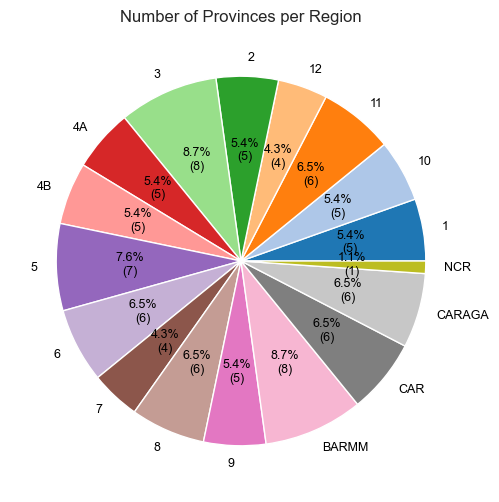

In [53]:
sns.set(style="whitegrid")

# 1. Province count per region (Pie chart with exact count + %)
province_count = standard_df.groupby('region_')['province_'].nunique()
print("\nProvince count per region:\n", province_count)

# Generate colors safely
colors = cm.tab20.colors[:len(province_count)]

# Pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    province_count,
    labels=province_count.index,
    colors=colors,
    autopct=lambda p: f"{p:.1f}%\n({int(round(p*sum(province_count)/100))})",
    textprops={'fontsize': 9, 'color': 'black'}
)
plt.title("Number of Provinces per Region", fontsize=12)
plt.show()


Persons affected per region:
 region_
3         15558849.0
5          9829248.0
6          8667010.0
1          6363124.0
4A         6182754.0
8          4816719.0
7          4578288.0
NCR        2730661.0
BARMM      2496402.0
2          2485773.0
4B         2212341.0
CARAGA     1964496.0
CAR        1226900.0
12          859385.0
9           353763.0
11          278819.0
10          247626.0
Name: person_sum, dtype: float64


C:\Users\Rodney Lei Estrada\AppData\Local\Temp\ipykernel_2016\3510998663.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=person_region.index, y=person_region.values, palette="Blues_r")


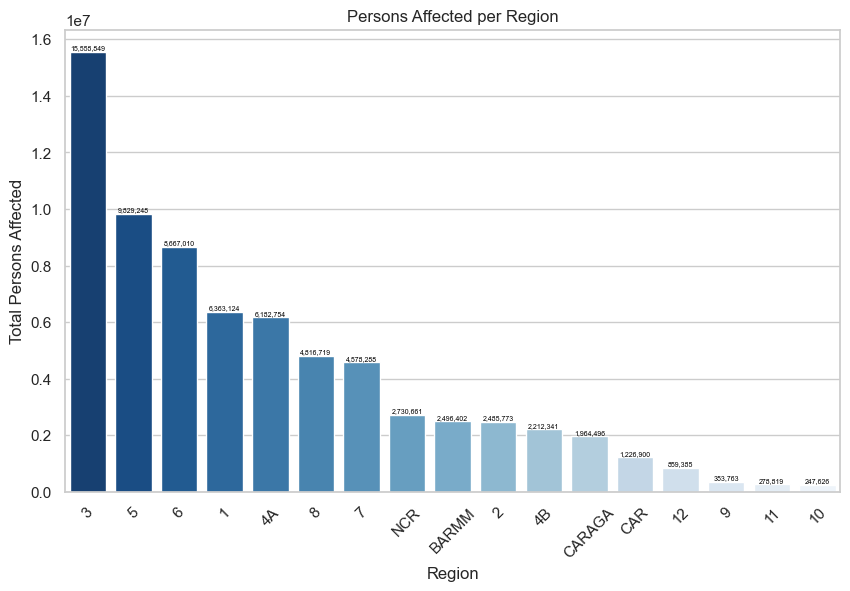

In [54]:
# 2. Persons affected per region (Bar chart, formatted numbers)
person_region = standard_df.groupby('region_')['person_sum'].sum().sort_values(ascending=False)
print("\nPersons affected per region:\n", person_region)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=person_region.index, y=person_region.values, palette="Blues_r")
plt.xticks(rotation=45)
plt.title('Persons Affected per Region')
plt.ylabel('Total Persons Affected')
plt.xlabel('Region')

for p in ax.patches:
    ax.annotate(f"{int(p.get_height()):,}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=5, color='black')

plt.show()


Casualties per region:
          dead_sum  injured_ill_sum  missing_sum
region_                                        
1            35.0              3.0         10.0
10           10.0             34.0          0.0
11            5.0              1.0          1.0
12            3.0             17.0          0.0
2             9.0             31.0          2.0
3            15.0             82.0          0.0
4A           22.0              9.0          1.0
4B           48.0             21.0          8.0
5            25.0             47.0          1.0
6           119.0            175.0         15.0
7           214.0            547.0         32.0
8           181.0            414.0          6.0
9             7.0              1.0          0.0
BARMM        66.0            169.0         13.0
CAR          18.0            198.0          4.0
CARAGA       22.0            500.0          0.0
NCR           0.0              0.0          0.0


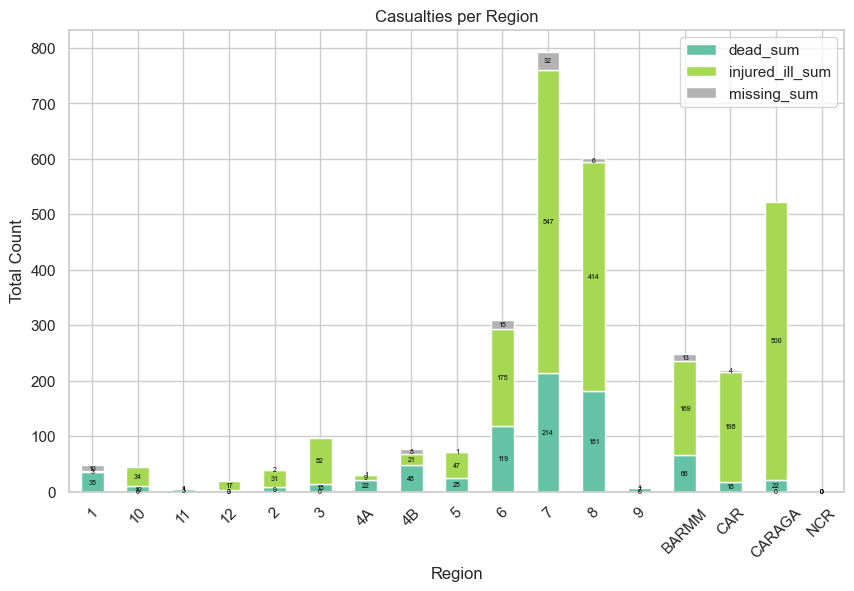

In [55]:
# 3. Casualties per region (Stacked Bar + labels)
casualties = standard_df.groupby('region_')[['dead_sum','injured_ill_sum','missing_sum']].sum()
print("\nCasualties per region:\n", casualties)

ax = casualties.plot(kind='bar', stacked=True, figsize=(10, 6), colormap="Set2")
plt.title('Casualties per Region')
plt.ylabel('Total Count')
plt.xlabel('Region')
plt.xticks(rotation=45)

for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=5, color='black')

plt.show()


Top 15 provinces by number of typhoons:
 province_
CAGAYAN              28
PAMPANGA             28
BULACAN              26
BENGUET              26
ILOILO               25
ANTIQUE              24
BATAAN               23
ALBAY                23
MOUNTAIN PROVINCE    22
NEGROS OCCIDENTAL    22
Name: num_typhoons, dtype: int64


C:\Users\Rodney Lei Estrada\AppData\Local\Temp\ipykernel_2016\4269437818.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=typhoons.values, y=typhoons.index, palette="Reds_r")


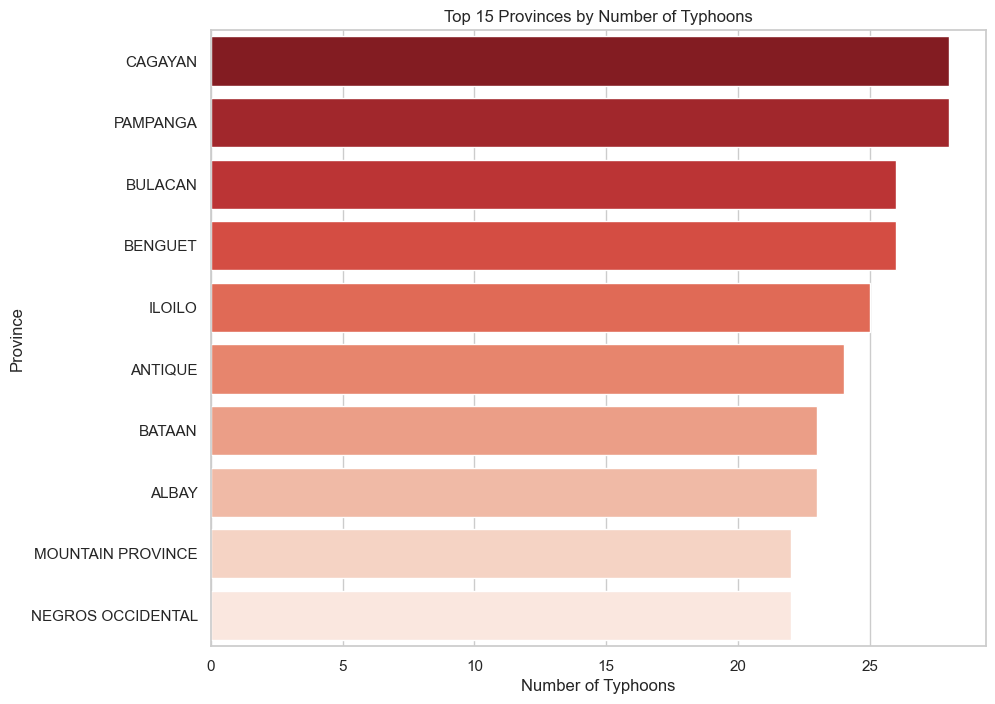

In [56]:
# 4. Top 15 Provinces by Number of Typhoons (Horizontal Bar)
typhoons = standard_df.groupby('province_')['num_typhoons'].max().sort_values(ascending=False).head(10)
print("\nTop 15 provinces by number of typhoons:\n", typhoons)

plt.figure(figsize=(10, 8))
ax = sns.barplot(x=typhoons.values, y=typhoons.index, palette="Reds_r")
plt.title('Top 15 Provinces by Number of Typhoons')
plt.xlabel('Number of Typhoons')
plt.ylabel('Province')
plt.show()


Aid/Support distribution per region:
          has_food_sum  has_cash_sum  has_hygiene_health_sum  \
region_                                                       
1                 158            12                      28   
10                 20             2                      10   
11                  7             3                       1   
12                 21            12                       3   
2                 350            32                      65   
3                 143             8                      15   
4A                 35            25                      20   
4B                195            14                      32   
5                 237            28                      11   
6                 542           321                      57   
7                 147             3                       0   
8                 154            37                      36   
9                  12             2                       3   
BARMM           

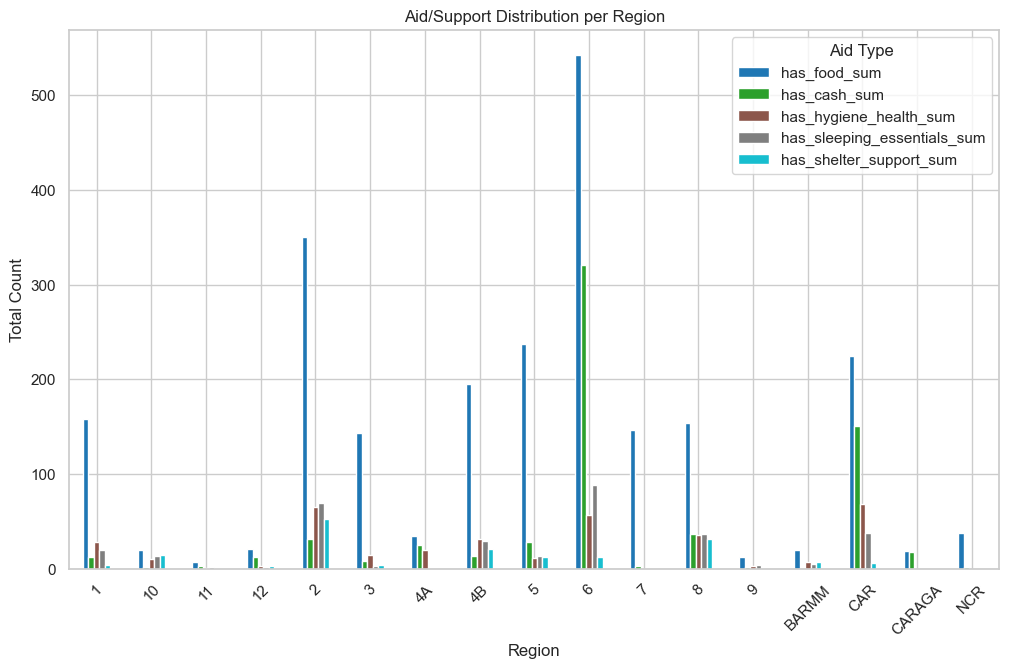

In [57]:
# 5. Aid/Support distribution per region (Grouped Bar)
aid = standard_df.groupby('region_')[['has_food_sum','has_cash_sum','has_hygiene_health_sum',
                                      'has_sleeping_essentials_sum','has_shelter_support_sum']].sum()
print("\nAid/Support distribution per region:\n", aid)

ax = aid.plot(kind='bar', figsize=(12, 7), colormap="tab10")
plt.title('Aid/Support Distribution per Region')
plt.ylabel('Total Count')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.legend(title='Aid Type')
plt.show()


Housing damage per region:
          totally_sum  partially_sum
region_                            
1            13898.0       157635.0
10             750.0         5987.0
11             425.0         2295.0
12             689.0         2741.0
2             3643.0        59089.0
3             1275.0         7718.0
4A           11879.0       113380.0
4B           22208.0       136926.0
5            59987.0       275794.0
6            59021.0       445374.0
7           245765.0       900987.0
8            61407.0       215707.0
9              524.0          786.0
BARMM         1345.0         1675.0
CAR            332.0         8136.0
CARAGA       67808.0       104093.0
NCR             20.0            0.0


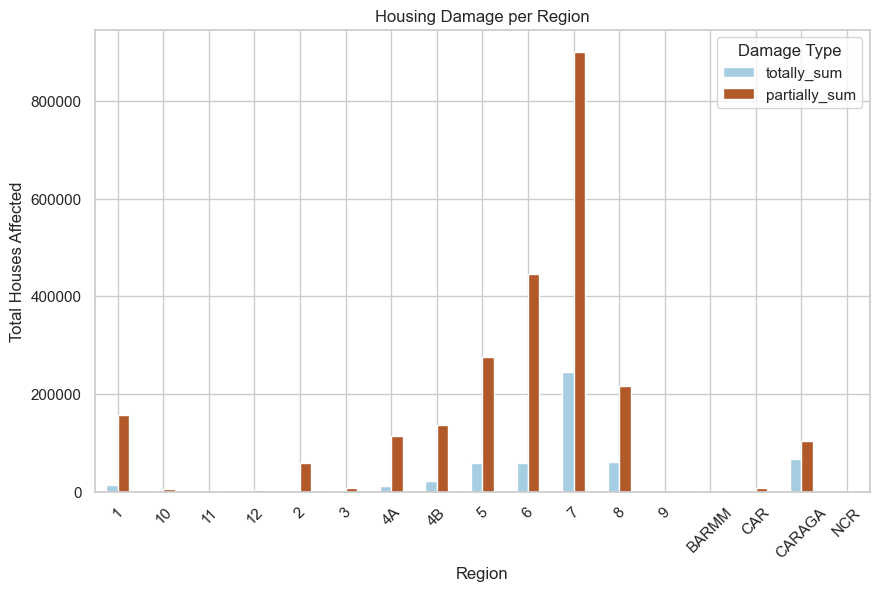

In [58]:
# 6. Housing damage per region (Grouped Bar)
damage = standard_df.groupby('region_')[['totally_sum','partially_sum']].sum()
print("\nHousing damage per region:\n", damage)

ax = damage.plot(kind='bar', figsize=(10, 6), colormap="Paired")
plt.title('Housing Damage per Region')
plt.ylabel('Total Houses Affected')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.legend(title='Damage Type')

plt.show()

In [59]:
# Get the total count of provinces
total_provinces = standard_df.shape[0]

# Get the total sum of families
total_families_sum = standard_df['families_sum'].sum()

# Get the total sum of people affected
total_person_sum = standard_df['person_sum'].sum()

# Print the results
print(f"Total number of provinces: {total_provinces}")
print(f"Total sum of families: {total_families_sum:,.0f}")
print(f"Total sum of people affected: {total_person_sum:,.0f}")

Total number of provinces: 1581
Total sum of families: 18,693,326
Total sum of people affected: 70,852,158


In [60]:
standard_df.head()

city_municipality_           province_ region_  families_sum  person_sum  \
0            ABORLAN             PALAWAN      4B        4110.0     19360.0   
1       ABRA DE ILOG  OCCIDENTAL MINDORO      4B        6479.0     26142.0   
2             ABUCAY                ABRA     CAR        7417.0     23141.0   
3             ABUCAY              BATAAN       3       31567.0     90540.0   
4             ABULUG             CAGAYAN       2       11102.0     35982.0   

   dead_sum  injured_ill_sum  missing_sum  totally_sum  partially_sum  \
0       0.0              0.0          0.0         39.0           75.0   
1       0.0              0.0          0.0         44.0          154.0   
2       0.0              0.0          0.0          0.0            4.0   
3       0.0              1.0          0.0          1.0            0.0   
4       0.0              0.0          0.0         45.0         1080.0   

     cost_sum  has_food_sum  has_cash_sum  has_hygiene_health_sum  \
0  1598114.84             3             0                       0   
1  3905094.30             4             0                       0   
2  5692829.60             2             1                       0   
3  3828511.82             1             0                       0   
4  2621472.79             7             0                       4   

   has_sleeping_essentials_sum  has_shelter_support_sum  first_year  \
0                            0                        1        2021   
1                            1                        0        2021   
2                            0                        0        2023   
3                            0                        0        2020   
4                            2                        1        2020   

   last_year  num_reports city_municipality_dup2       province_dup2  \
0       2025            3                ABORLAN             PALAWAN   
1       2025            8           ABRA DE ILOG  OCCIDENTAL MINDORO   
2       2025            5                 ABUCAY                ABRA   
3       2025            6                 ABUCAY              BATAAN   
4       2025           11                 ABULUG             CAGAYAN   

  region_dup2  num_typhoons  recurrence_rate  cost_per_family  
0          4B             5         1.000000       388.835727  
1          4B            15         3.000000       602.731023  
2         CAR            13         4.333333       767.538034  
3           3            14         2.333333       121.282093  
4           2            17         2.833333       236.126175

#### Applying Standard Scaling

In [61]:
from sklearn.preprocessing import StandardScaler

final_df = city_df.copy()
numerical_cols = city_df.select_dtypes(include=np.number).columns.tolist()
print(f"numerical_columns: {numerical_cols}")

scaler = StandardScaler()
city_df[numerical_cols] = scaler.fit_transform(city_df[numerical_cols])

print("DataFrame after Standard Scaling:")
display(city_df.head())

numerical_columns: ['person_sum', 'dead_sum', 'injured_ill_sum', 'missing_sum', 'totally_sum', 'partially_sum', 'cost_sum', 'has_food_sum', 'has_cash_sum', 'has_hygiene_health_sum', 'has_sleeping_essentials_sum', 'has_shelter_support_sum', 'num_typhoons', 'recurrence_rate', 'cost_per_family']
DataFrame after Standard Scaling:


province_ region_  \
city_province_region                                                 
ABORLAN - PALAWAN (4B)                             PALAWAN      4B   
ABRA DE ILOG - OCCIDENTAL MINDORO (4B)  OCCIDENTAL MINDORO      4B   
ABUCAY - ABRA (CAR)                                   ABRA     CAR   
ABUCAY - BATAAN (3)                                 BATAAN       3   
ABULUG - CAGAYAN (2)                               CAGAYAN       2   

                                        person_sum  dead_sum  injured_ill_sum  \
city_province_region                                                            
ABORLAN - PALAWAN (4B)                   -0.293086  -0.15466        -0.122249   
ABRA DE ILOG - OCCIDENTAL MINDORO (4B)   -0.214998  -0.15466        -0.122249   
ABUCAY - ABRA (CAR)                      -0.249552  -0.15466        -0.122249   
ABUCAY - BATAAN (3)                       0.526481  -0.15466        -0.036310   
ABULUG - CAGAYAN (2)                     -0.101701  -0.15466        -0.122249   

                                        missing_sum  totally_sum  \
city_province_region                                               
ABORLAN - PALAWAN (4B)                    -0.135144    -0.237012   
ABRA DE ILOG - OCCIDENTAL MINDORO (4B)    -0.135144    -0.233183   
ABUCAY - ABRA (CAR)                       -0.135144    -0.266878   
ABUCAY - BATAAN (3)                       -0.135144    -0.266112   
ABULUG - CAGAYAN (2)                      -0.135144    -0.232417   

                                        partially_sum  cost_sum  has_food_sum  \
city_province_region                                                            
ABORLAN - PALAWAN (4B)                      -0.305520 -0.228179      0.895446   
ABRA DE ILOG - OCCIDENTAL MINDORO (4B)      -0.289070  0.045938      1.480447   
ABUCAY - ABRA (CAR)                         -0.320304  0.258358      0.310446   
ABUCAY - BATAAN (3)                         -0.321137  0.036839     -0.274554   
ABULUG - CAGAYAN (2)                        -0.096255 -0.106583      3.235448   

                                        has_cash_sum  has_hygiene_health_sum  \
city_province_region                                                           
ABORLAN - PALAWAN (4B)                     -0.422042               -0.389703   
ABRA DE ILOG - OCCIDENTAL MINDORO (4B)     -0.422042               -0.389703   
ABUCAY - ABRA (CAR)                         0.573851               -0.389703   
ABUCAY - BATAAN (3)                        -0.422042               -0.389703   
ABULUG - CAGAYAN (2)                       -0.422042                6.532998   

                                        has_sleeping_essentials_sum  \
city_province_region                                                  
ABORLAN - PALAWAN (4B)                                    -0.397816   
ABRA DE ILOG - OCCIDENTAL MINDORO (4B)                     1.525568   
ABUCAY - ABRA (CAR)                                       -0.397816   
ABUCAY - BATAAN (3)                                       -0.397816   
ABULUG - CAGAYAN (2)                                       3.448951   

                                        has_shelter_support_sum  num_typhoons  \
city_province_region                                                            
ABORLAN - PALAWAN (4B)                                 2.583525     -0.632773   
ABRA DE ILOG - OCCIDENTAL MINDORO (4B)                -0.309218      1.043525   
ABUCAY - ABRA (CAR)                                   -0.309218      0.708265   
ABUCAY - BATAAN (3)                                   -0.309218      0.875895   
ABULUG - CAGAYAN (2)                                   2.583525      1.378784   

                                        recurrence_rate  cost_per_family  
city_province_region                                                      
ABORLAN - PALAWAN (4B)                        -1.148564        -0.036979  
ABRA DE ILOG - OCCIDENTAL MINDORO (4B)         0.954649         0.006809  
ABUCAY - ABRA (CAR

In [62]:
# PCA ANALYSIS WITH EXPLAINED VARIANCE + 3D VISUALIZATION

print("PCA ANALYSIS ON SCALED NUMERICAL FEATURES")

# --- Select numeric features ---
numeric_features = city_df.select_dtypes(include=np.number).columns.tolist()
X_viz = city_df[numeric_features].copy()

# --- Perform PCA ---
pca = PCA()
X_pca = pca.fit_transform(X_viz)

# --- Calculate cumulative variance ---
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

# --- Print explained variance summary ---
print(f"\nExplained Variance by Component:")
for i, var in enumerate(pca.explained_variance_ratio_[:10], 1):
    cum_var = cumulative_variance[i-1]
    print(f"  PC{i}: {var:.4f} ({var*100:.2f}%) | Cumulative: {cum_var*100:.2f}%")

print(f"\nComponents needed for 90% variance: {n_components_90}")
print(f"Components needed for 95% variance: {n_components_95}")

# --- Create explained variance table ---
explained_variance_table = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'Explained Variance Ratio': pca.explained_variance_ratio_,
    'Cumulative Variance': cumulative_variance
}).round(4)

print("\nExplained Variance Table:")
display(explained_variance_table.head(10))  # show first 10 PCs

# --- 3D PCA Visualization (no clusters) ---
pca_df = pd.DataFrame(X_pca[:, :3], columns=['PC1', 'PC2', 'PC3'])
if 'province' in city_df.columns:
    pca_df['province'] = city_df['province']

fig = px.scatter_3d(
    pca_df,
    x='PC1', y='PC2', z='PC3',
    hover_name='province' if 'province' in pca_df.columns else None,
    title=f'3D PCA Visualization (Explains {cumulative_variance[2]*100:.1f}% Variance)',
    labels={
        'PC1': f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)',
        'PC2': f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)',
        'PC3': f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)'
    }
)

fig.update_traces(marker=dict(size=6, color='royalblue', line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(height=700)
fig.show()


PCA ANALYSIS ON SCALED NUMERICAL FEATURES

Explained Variance by Component:
  PC1: 0.2432 (24.32%) | Cumulative: 24.32%
  PC2: 0.1701 (17.01%) | Cumulative: 41.33%
  PC3: 0.1018 (10.18%) | Cumulative: 51.50%
  PC4: 0.0827 (8.27%) | Cumulative: 59.77%
  PC5: 0.0677 (6.77%) | Cumulative: 66.54%
  PC6: 0.0631 (6.31%) | Cumulative: 72.84%
  PC7: 0.0544 (5.44%) | Cumulative: 78.28%
  PC8: 0.0426 (4.26%) | Cumulative: 82.55%
  PC9: 0.0368 (3.68%) | Cumulative: 86.22%
  PC10: 0.0341 (3.41%) | Cumulative: 89.63%

Components needed for 90% variance: 11
Components needed for 95% variance: 12

Explained Variance Table:


Principal Component  Explained Variance Ratio  Cumulative Variance
0                 PC1                    0.2432               0.2432
1                 PC2                    0.1701               0.4133
2                 PC3                    0.1018               0.5150
3                 PC4                    0.0827               0.5977
4                 PC5                    0.0677               0.6654
5                 PC6                    0.0631               0.7284
6                 PC7                    0.0544               0.7828
7                 PC8                    0.0426               0.8255
8                 PC9                    0.0368               0.8622
9                PC10                    0.0341               0.8963

### Labeling Categorical and Numerical Data Columns

In [63]:
city_df.columns = city_df.columns.str.strip()
city_df['region_'] = city_df['region_'].astype(str)

categorical_columns = ['region_', 'province_']
categorical_indices = [city_df.columns.get_loc(col) for col in categorical_columns]

### Silhoutte Score

In [64]:
# Prepare data for Gower (exclude nothing yet — we'll drop 'cluster' later if present)
X_for_gower = city_df.drop(columns=['cluster'], errors='ignore').copy()

print("Computing Gower distance matrix (one-time, may take a moment)...")
gower_dist = gower.gower_matrix(X_for_gower)
print("Gower distance computed!")

k_range = range(2, 12)
silhouette_scores = []
costs = []

print("\nRunning K-Prototypes for k = 2 to 10...")
for k in k_range:
    print(f"  k = {k} ...", end="")

    # Run K-Prototypes
    kproto = KPrototypes(
        n_clusters=k,
        init='Huang',
        n_init=10,
        verbose=0,
        random_state=42
    )

    X = city_df.drop(columns=['cluster'], errors='ignore').values.astype(object)
    clusters = kproto.fit_predict(X, categorical=categorical_indices)

    # Compute silhouette score using precomputed Gower distance
    sil_score = silhouette_score(gower_dist, clusters, metric='precomputed')

    # Store results
    silhouette_scores.append(sil_score)
    costs.append(kproto.cost_)

    print(f" Silhouette = {sil_score:.4f}, Cost = {kproto.cost_:.2f}")


Computing Gower distance matrix (one-time, may take a moment)...
Gower distance computed!

Running K-Prototypes for k = 2 to 10...
  k = 2 ... Silhouette = 0.2513, Cost = 21457.05
  k = 3 ... Silhouette = 0.2351, Cost = 19096.37
  k = 4 ... Silhouette = 0.1440, Cost = 17380.13
  k = 5 ... Silhouette = 0.1327, Cost = 15828.97
  k = 6 ... Silhouette = 0.0912, Cost = 15207.28
  k = 7 ... Silhouette = 0.1293, Cost = 13896.90
  k = 8 ... Silhouette = 0.1005, Cost = 13589.62
  k = 9 ... Silhouette = 0.0936, Cost = 12282.02
  k = 10 ... Silhouette = 0.0799, Cost = 11989.59
  k = 11 ... Silhouette = 0.0781, Cost = 11575.45


### Grid Search

In [65]:

param_grid = {
    'n_clusters': range(2, 11),  # Number of clusters to test
    'init': ['Huang', 'Cao'],   # Initialization methods
    'n_init': [5, 10]          # Number of initializations
}

# Create a list of parameter combinations
grid = ParameterGrid(param_grid)

best_score = -1
best_params = None
results = []

print("Starting Grid Search for K-Prototypes...")
print("-" * 30)

# Prepare the data (Include data prep from the previous successful cell)
numerical_cols = city_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = city_df.select_dtypes(include='object').columns.tolist()

# Separate numerical and categorical data
X_numerical = city_df[numerical_cols].values
X_categorical = city_df[categorical_cols].values

# Combine the data for K-Prototypes. K-Prototypes expects categorical features last.
X = np.concatenate((X_numerical, X_categorical), axis=1)

# Get the indices of categorical columns in the combined matrix
# They will be after all numerical columns
categorical_indices_combined = list(range(X_numerical.shape[1], X.shape[1]))

# Compute Gower distance matrix (if using precomputed metric for silhouette)
# Make sure 'gower_dist' is computed before the loop if metric='precomputed'
X_for_gower = city_df.drop(columns=['cluster'], errors='ignore').copy() # Re-create if needed
print("Computing Gower distance matrix (one-time, may take a moment)...")
gower_dist = gower.gower_matrix(X_for_gower) # Compute if needed
print("Gower distance computed!")


for params in grid:
    n_clusters = params['n_clusters']
    init_method = params['init']
    n_init = params['n_init']

    print(f"Testing params: k={n_clusters}, init='{init_method}', n_init={n_init}")

    try:
        # Initialize and train K-Prototypes model
        kp = KPrototypes(
            n_clusters=n_clusters,
            init=init_method,
            n_init=n_init,
            verbose=0, # Set verbose to 0 for cleaner grid search output
            random_state=42
        )
        clusters = kp.fit_predict(X, categorical=categorical_indices_combined)
        score = silhouette_score(gower_dist, clusters, metric='precomputed')


        results.append({
            'n_clusters': n_clusters,
            'init': init_method,
            'n_init': n_init,
            'silhouette_score': score,
            'cost': kp.cost_
        })

        print(f"  Silhouette Score: {score:.4f}, Cost: {kp.cost_:.2f}")

        # Check for best score
        if score > best_score:
            best_score = score
            best_params = params

    except Exception as e:
        print(f"  Error with params {params}: {e}")
        results.append({
            'n_clusters': n_clusters,
            'init': init_method,
            'n_init': n_init,
            'silhouette_score': None,
            'cost': None,
            'error': str(e)
        })


print("-" * 30)
print("\nGrid Search Complete.")
print(f"Best Silhouette Score: {best_score:.4f}")
print(f"Best Parameters: {best_params}")

# Optional: Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results)
display(results_df.sort_values(by='silhouette_score', ascending=False))

# Restore warnings
warnings.filterwarnings("default", category=DeprecationWarning)
warnings.filterwarnings("default", category=UserWarning)

Starting Grid Search for K-Prototypes...
------------------------------
Computing Gower distance matrix (one-time, may take a moment)...
Gower distance computed!
Testing params: k=2, init='Huang', n_init=5
  Silhouette Score: 0.2513, Cost: 21457.05
Testing params: k=2, init='Huang', n_init=10
  Silhouette Score: 0.2513, Cost: 21457.05
Testing params: k=3, init='Huang', n_init=5
  Silhouette Score: 0.2349, Cost: 19110.65
Testing params: k=3, init='Huang', n_init=10
  Silhouette Score: 0.2351, Cost: 19096.37
Testing params: k=4, init='Huang', n_init=5
  Silhouette Score: 0.1440, Cost: 17380.13
Testing params: k=4, init='Huang', n_init=10
  Silhouette Score: 0.1440, Cost: 17380.13
Testing params: k=5, init='Huang', n_init=5
  Silhouette Score: 0.1327, Cost: 15829.07
Testing params: k=5, init='Huang', n_init=10
  Silhouette Score: 0.1327, Cost: 15829.07
Testing params: k=6, init='Huang', n_init=5
  Silhouette Score: 0.1184, Cost: 15575.81
Testing params: k=6, init='Huang', n_init=10
  Silh

n_clusters   init  n_init  silhouette_score          cost
19           2    Cao      10          0.251879  21457.071868
0            2  Huang       5          0.251279  21457.050015
1            2  Huang      10          0.251279  21457.050015
18           2    Cao       5          0.244834  21458.103267
21           3    Cao      10          0.235091  19148.098681
3            3  Huang      10          0.235087  19096.374479
2            3  Huang       5          0.234931  19110.649893
27           6    Cao      10          0.145950  14964.821052
26           6    Cao       5          0.145950  14964.821052
22           4    Cao       5          0.144575  17413.355441
23           4    Cao      10          0.144502  17413.343332
4            4  Huang       5          0.143978  17380.127315
5            4  Huang      10          0.143978  17380.127315
20           3    Cao       5          0.143948  19683.471878
24           5    Cao       5          0.137461  15925.085431
25           5    Cao      10          0.136374  15924.943721
6            5  Huang       5          0.132717  15829.066388
7            5  Huang      10          0.132717  15829.066388
31           8    Cao      10          0.130635  12969.808958
11           7  Huang      10          0.129337  13896.904620
10           7  Huang       5          0.129337  13896.904620
8            6  Huang       5          0.118384  15575.808436
29           7    Cao      10          0.117471  14080.432788
28           7    Cao       5          0.117471  14080.432788
30           8    Cao       5          0.109872  12970.218700
32           9    Cao       5          0.107100  11933.157492
33           9    Cao      10          0.107100  11933.157492
12           8  Huang       5          0.100315  13414.826767
13           8  Huang      10          0.099497  13360.993705
15           9  Huang      10          0.093634  12282.019277
14           9  Huang       5          0.093634  12282.019277
17          10  Huang      10          0.093507  11530.515370
9            6  Huang      10          0.091156  15207.282692
16          10  Huang       5          0.078980  12104.131188
34          10    Cao       5          0.078260  11903.240511
35          10    Cao      10          0.078260  11903.240511

### Optuna Bayesian / Smart Search

In [66]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message=".*datetime.datetime.utcnow.*"
)


In [67]:
numerical_cols = city_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = city_df.select_dtypes(include='object').columns.tolist()

X_numerical = city_df[numerical_cols].values
X_categorical = city_df[categorical_cols].values

X = np.concatenate((X_numerical, X_categorical), axis=1)
categorical_indices_combined = list(range(X_numerical.shape[1], X.shape[1]))

# Compute Gower distance once for silhouette
print("Computing Gower distance matrix (one-time, may take a moment)...")
X_for_gower = city_df.drop(columns=['cluster'], errors='ignore').copy()
gower_dist = gower.gower_matrix(X_for_gower)
print("Gower distance computed!")

def objective(trial):
    # n_clusters = trial.suggest_int("n_clusters", 2, 10)  # cluster range
    n_clusters = 3
    init_method = trial.suggest_categorical("init", ["Huang", "Cao"])
    n_init = trial.suggest_int("n_init", 5, 15)
    gamma = trial.suggest_float("gamma", 0.1, 5.0)  # categorical weight

    try:
        model = KPrototypes(
            n_clusters=n_clusters,
            init=init_method,
            n_init=n_init,
            gamma=gamma,
            verbose=0,
            random_state=42
        )
        clusters = model.fit_predict(X, categorical=categorical_indices_combined)

        # Use silhouette with precomputed Gower distance
        score = silhouette_score(gower_dist, clusters, metric="precomputed")
        return score

    except Exception as e:
        # Failures return very low score
        return -1.0

# Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # try 50 trials


print("\n📊 Optuna Search Complete!")
print("Best Silhouette Score:", study.best_value)
print("Best Parameters:", study.best_trial.params)

optuna_results = study.trials_dataframe(attrs=("number", "value", "params", "state"))
optuna_results = optuna_results.sort_values(by="value", ascending=False)
display(optuna_results.head(20))


Computing Gower distance matrix (one-time, may take a moment)...


[I 2025-10-07 22:20:12,890] A new study created in memory with name: no-name-c2b20819-21ca-4a47-8224-554ffec02ab3


Gower distance computed!


[I 2025-10-07 22:20:24,455] Trial 0 finished with value: 0.23238447308540344 and parameters: {'init': 'Huang', 'n_init': 13, 'gamma': 1.6477812511567576}. Best is trial 0 with value: 0.23238447308540344.
[I 2025-10-07 22:20:33,286] Trial 1 finished with value: 0.2254755198955536 and parameters: {'init': 'Cao', 'n_init': 8, 'gamma': 4.570070100605175}. Best is trial 0 with value: 0.23238447308540344.
[I 2025-10-07 22:20:40,641] Trial 2 finished with value: 0.23164887726306915 and parameters: {'init': 'Huang', 'n_init': 8, 'gamma': 1.1117152813779536}. Best is trial 0 with value: 0.23238447308540344.
[I 2025-10-07 22:20:51,231] Trial 3 finished with value: 0.2270497828722 and parameters: {'init': 'Cao', 'n_init': 9, 'gamma': 3.766480056207164}. Best is trial 0 with value: 0.23238447308540344.
[I 2025-10-07 22:20:58,917] Trial 4 finished with value: 0.22091132402420044 and parameters: {'init': 'Huang', 'n_init': 7, 'gamma': 4.348446891862304}. Best is trial 0 with value: 0.232384473085403


📊 Optuna Search Complete!
Best Silhouette Score: 0.23958030343055725
Best Parameters: {'init': 'Huang', 'n_init': 13, 'gamma': 0.19833500315935648}


number     value  params_gamma params_init  params_n_init     state
13      13  0.239580      0.198335       Huang             13  COMPLETE
15      15  0.239580      0.177814       Huang             11  COMPLETE
33      33  0.239580      0.105782       Huang             12  COMPLETE
44      44  0.239580      0.103520       Huang             11  COMPLETE
41      41  0.239580      0.134349       Huang             11  COMPLETE
31      31  0.239580      0.165578       Huang             13  COMPLETE
21      21  0.239580      0.171173       Huang             13  COMPLETE
24      24  0.239580      0.148024       Huang             11  COMPLETE
19      19  0.239580      0.113810       Huang             13  COMPLETE
14      14  0.239104      0.332179       Huang             10  COMPLETE
32      32  0.239104      0.350004       Huang             13  COMPLETE
49      49  0.239104      0.347562       Huang             14  COMPLETE
42      42  0.239104      0.414510       Huang             12  COMPLETE
35      35  0.239104      0.412200       Huang             15  COMPLETE
46      46  0.239104      0.374257       Huang              7  COMPLETE
25      25  0.235087      0.593346       Huang             14  COMPLETE
36      36  0.235087      0.497595       Huang             13  COMPLETE
28      28  0.235087      0.558351       Huang             13  COMPLETE
43      43  0.235087      0.731279       Huang             13  COMPLETE
47      47  0.235087      0.779138       Huang              9  COMPLETE

In [68]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Copy the city-level DataFrame
city_df_kmeans = city_df.copy()

# Separate numerical and categorical columns
numerical_cols = [
    'person_sum', 'dead_sum', 'injured_ill_sum', 'missing_sum',
    'totally_sum', 'partially_sum', 'cost_sum',
    'has_food_sum', 'has_cash_sum', 'has_hygiene_health_sum',
    'has_sleeping_essentials_sum', 'has_shelter_support_sum',
    'num_typhoons', 'recurrence_rate', 'cost_per_family'
]
categorical_cols = ['province_', 'region_']

# Extract numerical and categorical values
X_num = city_df_kmeans[numerical_cols].values
X_cat = city_df_kmeans[categorical_cols].values

# ======================
# 1️⃣ One-Hot Encoding
# ======================
ohe = OneHotEncoder(sparse_output=False, drop='first')
X_cat_ohe = ohe.fit_transform(X_cat)

# Combine numerical + one-hot encoded categorical
X_ohe = np.hstack([X_num, X_cat_ohe])

# Train KMeans
kmeans_ohe = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_ohe_labels = kmeans_ohe.fit_predict(X_ohe)

# Evaluate silhouette score
silhouette_ohe = silhouette_score(X_ohe, kmeans_ohe_labels)
city_df_kmeans["kmeans_ohe_cluster"] = kmeans_ohe_labels

print(f"KMeans (One-Hot Encoded) Silhouette Score: {silhouette_ohe:.3f}")

# ======================
# 2️⃣ Label Encoding
# ======================
le_province = LabelEncoder()
le_region = LabelEncoder()

# Apply label encoding separately for each categorical column
province_le = le_province.fit_transform(city_df_kmeans['province_'])
region_le = le_region.fit_transform(city_df_kmeans['region_'])

# Combine encoded columns
X_cat_le = np.column_stack((province_le, region_le))

# Combine numerical + label encoded categorical
X_le = np.hstack([X_num, X_cat_le])

# Train KMeans
kmeans_le = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_le_labels = kmeans_le.fit_predict(X_le)

# Evaluate silhouette score
silhouette_le = silhouette_score(X_le, kmeans_le_labels)
city_df_kmeans["kmeans_le_cluster"] = kmeans_le_labels

print(f"KMeans (Label Encoded) Silhouette Score: {silhouette_le:.3f}")


KMeans (One-Hot Encoded) Silhouette Score: 0.356
KMeans (Label Encoded) Silhouette Score: 0.530


In [69]:
city_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1581 entries, ABORLAN - PALAWAN (4B) to ZUMARRAGA - SAMAR (8)
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   province_                    1581 non-null   object 
 1   region_                      1581 non-null   object 
 2   person_sum                   1581 non-null   float64
 3   dead_sum                     1581 non-null   float64
 4   injured_ill_sum              1581 non-null   float64
 5   missing_sum                  1581 non-null   float64
 6   totally_sum                  1581 non-null   float64
 7   partially_sum                1581 non-null   float64
 8   cost_sum                     1581 non-null   float64
 9   has_food_sum                 1581 non-null   float64
 10  has_cash_sum                 1581 non-null   float64
 11  has_hygiene_health_sum       1581 non-null   float64
 12  has_sleeping_essentials_sum  1581 non-null 

#### Training the model kprototypes

In [70]:
from kmodes.kprototypes import KPrototypes

best_params = study.best_trial.params
print("Best Params:", best_params)

numerical_cols = city_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = city_df.select_dtypes(include="object").columns.tolist()

X_numerical = city_df[numerical_cols].values
X_categorical = city_df[categorical_cols].values

X = np.concatenate((X_numerical, X_categorical), axis=1)

categorical_indices = list(range(X_numerical.shape[1], X.shape[1]))

kproto_final = KPrototypes(
    n_clusters=3,
    init=best_params.get("init", "Cao"),
    n_init=best_params.get("n_init", 10),
    gamma=best_params.get("gamma", None),
    random_state=42,
    verbose=1
)

clusters = kproto_final.fit_predict(X, categorical=categorical_indices)

final_df["cluster"] = clusters
city_df.head()


Best Params: {'init': 'Huang', 'n_init': 13, 'gamma': 0.19833500315935648}
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 610, ncost: 19286.35591575479
Run: 1, iteration: 2/100, moves: 194, ncost: 18895.566719166414
Run: 1, iteration: 3/100, moves: 47, ncost: 18850.025496873135
Run: 1, iteration: 4/100, moves: 14, ncost: 18845.85127632748
Run: 1, iteration: 5/100, moves: 3, ncost: 18845.05073743503
Run: 1, iteration: 6/100, moves: 7, ncost: 18843.789229456528
Run: 1, iteration: 7/100, moves: 2, ncost: 18843.62950126896
Run: 1, iteration: 8/100, moves: 0, ncost: 18843.62950126896
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 237, ncost: 18530.475781350284
Run: 2, iteration: 2/100, moves: 35, ncost: 18436.898537190744
Run: 2, iteration: 3/100, moves: 19, ncost: 18309.144012771085
Run: 2, iteration: 4/100, moves: 11, ncost: 18264.197470829175
Run: 2, iterati

province_ region_  \
city_province_region                                                 
ABORLAN - PALAWAN (4B)                             PALAWAN      4B   
ABRA DE ILOG - OCCIDENTAL MINDORO (4B)  OCCIDENTAL MINDORO      4B   
ABUCAY - ABRA (CAR)                                   ABRA     CAR   
ABUCAY - BATAAN (3)                                 BATAAN       3   
ABULUG - CAGAYAN (2)                               CAGAYAN       2   

                                        person_sum  dead_sum  injured_ill_sum  \
city_province_region                                                            
ABORLAN - PALAWAN (4B)                   -0.293086  -0.15466        -0.122249   
ABRA DE ILOG - OCCIDENTAL MINDORO (4B)   -0.214998  -0.15466        -0.122249   
ABUCAY - ABRA (CAR)                      -0.249552  -0.15466        -0.122249   
ABUCAY - BATAAN (3)                       0.526481  -0.15466        -0.036310   
ABULUG - CAGAYAN (2)                     -0.101701  -0.15466        -0.122249   

                                        missing_sum  totally_sum  \
city_province_region                                               
ABORLAN - PALAWAN (4B)                    -0.135144    -0.237012   
ABRA DE ILOG - OCCIDENTAL MINDORO (4B)    -0.135144    -0.233183   
ABUCAY - ABRA (CAR)                       -0.135144    -0.266878   
ABUCAY - BATAAN (3)                       -0.135144    -0.266112   
ABULUG - CAGAYAN (2)                      -0.135144    -0.232417   

                                        partially_sum  cost_sum  has_food_sum  \
city_province_region                                                            
ABORLAN - PALAWAN (4B)                      -0.305520 -0.228179      0.895446   
ABRA DE ILOG - OCCIDENTAL MINDORO (4B)      -0.289070  0.045938      1.480447   
ABUCAY - ABRA (CAR)                         -0.320304  0.258358      0.310446   
ABUCAY - BATAAN (3)                         -0.321137  0.036839     -0.274554   
ABULUG - CAGAYAN (2)                        -0.096255 -0.106583      3.235448   

                                        has_cash_sum  has_hygiene_health_sum  \
city_province_region                                                           
ABORLAN - PALAWAN (4B)                     -0.422042               -0.389703   
ABRA DE ILOG - OCCIDENTAL MINDORO (4B)     -0.422042               -0.389703   
ABUCAY - ABRA (CAR)                         0.573851               -0.389703   
ABUCAY - BATAAN (3)                        -0.422042               -0.389703   
ABULUG - CAGAYAN (2)                       -0.422042                6.532998   

                                        has_sleeping_essentials_sum  \
city_province_region                                                  
ABORLAN - PALAWAN (4B)                                    -0.397816   
ABRA DE ILOG - OCCIDENTAL MINDORO (4B)                     1.525568   
ABUCAY - ABRA (CAR)                                       -0.397816   
ABUCAY - BATAAN (3)                                       -0.397816   
ABULUG - CAGAYAN (2)                                       3.448951   

                                        has_shelter_support_sum  num_typhoons  \
city_province_region                                                            
ABORLAN - PALAWAN (4B)                                 2.583525     -0.632773   
ABRA DE ILOG - OCCIDENTAL MINDORO (4B)                -0.309218      1.043525   
ABUCAY - ABRA (CAR)                                   -0.309218      0.708265   
ABUCAY - BATAAN (3)                                   -0.309218      0.875895   
ABULUG - CAGAYAN (2)                                   2.583525      1.378784   

                                        recurrence_rate  cost_per_family  
city_province_region                                                      
ABORLAN - PALAWAN (4B)                        -1.148564        -0.036979  
ABRA DE ILOG - OCCIDENTAL MINDORO (4B)         0.954649         0.006809  
ABUCAY - ABRA (CAR


=== Clustering Comparison (with Gower for K-Prototypes) ===
K-Prototypes (Gower)        : 0.240
KMeans (One-Hot Encoded)    : 0.356
KMeans (Label Encoded)      : 0.530


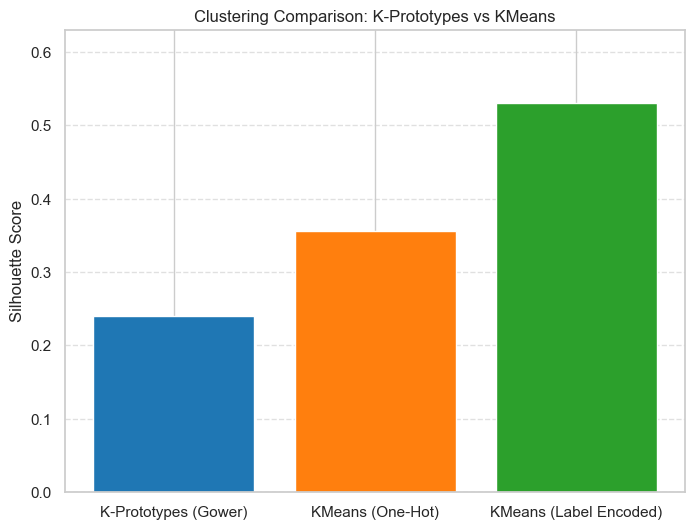

In [71]:
# --- Gower distance for mixed data ---
X_for_gower = city_df.drop(columns=['cluster'], errors='ignore').copy()
gower_dist = gower.gower_matrix(X_for_gower)

print("\n=== Clustering Comparison (with Gower for K-Prototypes) ===")
print(f"K-Prototypes (Gower)        : {study.best_value:.3f}")
print(f"KMeans (One-Hot Encoded)    : {silhouette_ohe:.3f}")
print(f"KMeans (Label Encoded)      : {silhouette_le:.3f}")

# --- Bar Chart Comparison ---
scores = {
    "K-Prototypes (Gower)": study.best_value,
    "KMeans (One-Hot)": silhouette_ohe,
    "KMeans (Label Encoded)": silhouette_le,
}

plt.figure(figsize=(8,6))
plt.bar(scores.keys(), scores.values(), color=['#1f77b4','#ff7f0e','#2ca02c'])
plt.ylabel("Silhouette Score")
plt.title("Clustering Comparison: K-Prototypes vs KMeans")
plt.ylim(0, max(scores.values())+0.1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


DEMONSTRATING K-PROTOTYPES ADVANTAGE FOR MIXED DATA

FEATURE SPACE DIMENSIONALITY COMPARISON

           Method Original Features  Feature Space Dimensions   Dimensionality Impact
     K-Prototypes    15 num + 2 cat                        17   Native mixed handling
  K-Means (Label)    15 num + 2 cat                        17   Artificial ordinality
K-Means (One-Hot)    15 num + 2 cat                       122 Curse of dimensionality

⚠️ One-Hot Encoding increased dimensions by 617.6%


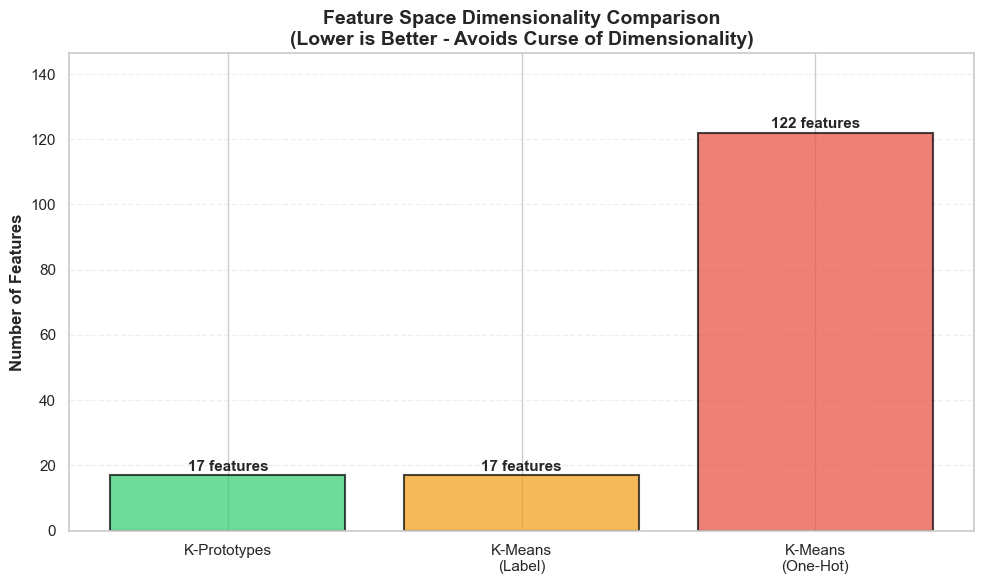


CLUSTER STABILITY ANALYSIS (Multiple Random Seeds)

Running clustering with 10 different random seeds...

Adjusted Rand Index (ARI) Statistics:
(Higher mean and lower std = More stable clustering)
           Method  Mean ARI  Std ARI  Min ARI  Max ARI
     K-Prototypes  0.936039 0.007256 0.925091 0.945577
K-Means (One-Hot)  0.886186 0.168236 0.402936 1.000000
  K-Means (Label)  1.000000 0.000000 1.000000 1.000000


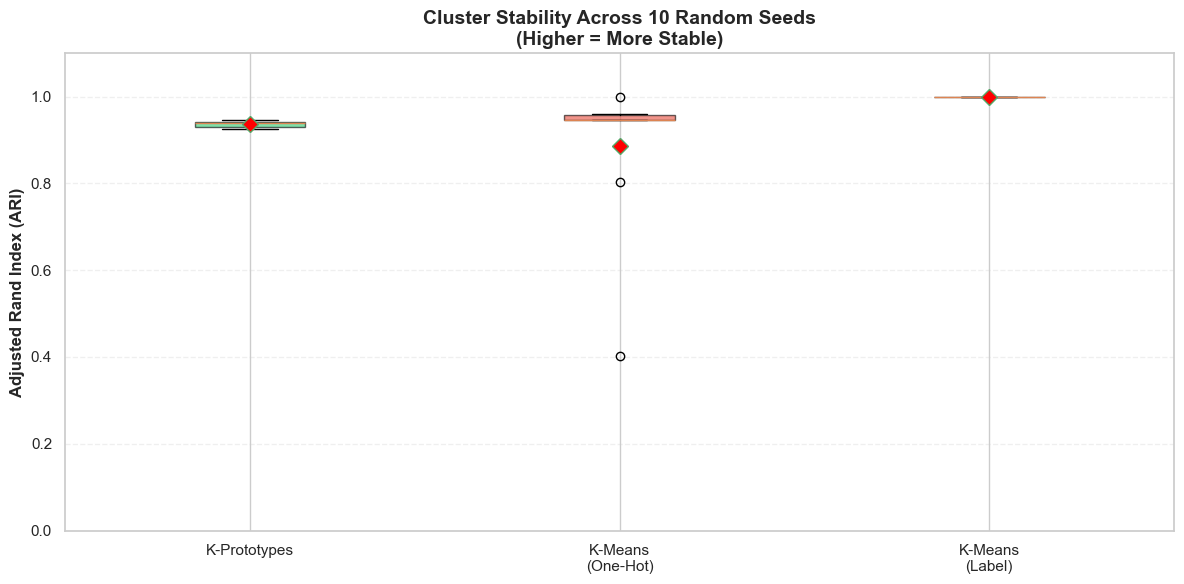

In [75]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes
import warnings
warnings.filterwarnings('ignore')

# Copy dataset
city_df_kmeans = city_df.copy()

# --- 1. Identify numerical + categorical columns ---
numerical_cols = city_df_kmeans.select_dtypes(include=np.number).columns.tolist()
categorical_cols = city_df_kmeans.select_dtypes(include="object").columns.tolist()

print("="*80)
print("DEMONSTRATING K-PROTOTYPES ADVANTAGE FOR MIXED DATA")
print("="*80)

# --- 2. Feature Space Dimensionality Comparison ---
print("\n" + "="*80)
print("FEATURE SPACE DIMENSIONALITY COMPARISON")
print("="*80)

# Separate numeric + categorical values
X_num = city_df_kmeans[numerical_cols].values
X_cat = city_df_kmeans[categorical_cols].values   # includes province_ and region_

# --- One-Hot Encoding ---
ohe = OneHotEncoder(sparse_output=False, drop='first')
X_cat_ohe = ohe.fit_transform(X_cat)
X_ohe = np.hstack([X_num, X_cat_ohe])

# --- Label Encoding ---
# Flatten each categorical column separately, since LabelEncoder only handles 1D arrays
encoded_cols = []
for col in categorical_cols:
    le = LabelEncoder()
    encoded_col = le.fit_transform(city_df_kmeans[col]).reshape(-1, 1)
    encoded_cols.append(encoded_col)
X_cat_le = np.hstack(encoded_cols)
X_le = np.hstack([X_num, X_cat_le])

# --- Display dimensionality ---
dim_comparison = pd.DataFrame({
    'Method': ['K-Prototypes', 'K-Means (Label)', 'K-Means (One-Hot)'],
    'Original Features': [f"{len(numerical_cols)} num + {len(categorical_cols)} cat"]*3,
    'Feature Space Dimensions': [
        len(numerical_cols) + len(categorical_cols),
        X_le.shape[1],
        X_ohe.shape[1]
    ],
    'Dimensionality Impact': [
        'Native mixed handling',
        'Artificial ordinality',
        'Curse of dimensionality'
    ]
})

print("\n" + dim_comparison.to_string(index=False))
print(f"\n⚠️ One-Hot Encoding increased dimensions by "
      f"{((X_ohe.shape[1] / (len(numerical_cols) + len(categorical_cols))) - 1) * 100:.1f}%")

# --- Visualize dimensionality ---
fig, ax = plt.subplots(figsize=(10, 6))
methods = ['K-Prototypes', 'K-Means\n(Label)', 'K-Means\n(One-Hot)']
dimensions = [len(numerical_cols) + len(categorical_cols), X_le.shape[1], X_ohe.shape[1]]
colors = ['#2ecc71', '#f39c12', '#e74c3c']

bars = ax.bar(methods, dimensions, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Number of Features', fontsize=12, fontweight='bold')
ax.set_title('Feature Space Dimensionality Comparison\n(Lower is Better - Avoids Curse of Dimensionality)', 
             fontsize=14, fontweight='bold')
ax.set_ylim(0, max(dimensions) * 1.2)
ax.grid(axis='y', alpha=0.3, linestyle='--')

for bar, dim in zip(bars, dimensions):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{dim} features', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


# --- 3. Cluster Stability Analysis ---
print("\n" + "="*80)
print("CLUSTER STABILITY ANALYSIS (Multiple Random Seeds)")
print("="*80)
print("\nRunning clustering with 10 different random seeds...")

# Store ARI scores
n_runs = 10
stability_kproto, stability_ohe, stability_le = [], [], []

# Baseline K-Prototypes cluster labels
baseline_kproto = final_df['cluster'].values

# Prepare mixed data for K-Prototypes (including both province_ and region_)
X_kproto = city_df_kmeans[numerical_cols + categorical_cols].values
cat_idx = list(range(len(numerical_cols), len(numerical_cols) + len(categorical_cols)))

for seed in range(n_runs):
    # K-Prototypes
    kproto_temp = KPrototypes(n_clusters=3, init='Cao', random_state=seed, n_init=5, verbose=0)
    temp_labels_kproto = kproto_temp.fit_predict(X_kproto, categorical=cat_idx)
    ari_kproto = adjusted_rand_score(baseline_kproto, temp_labels_kproto)
    stability_kproto.append(ari_kproto)

    # K-Means (One-Hot)
    kmeans_temp_ohe = KMeans(n_clusters=3, random_state=seed, n_init=10)
    temp_labels_ohe = kmeans_temp_ohe.fit_predict(X_ohe)
    ari_ohe = adjusted_rand_score(kmeans_ohe_labels, temp_labels_ohe)
    stability_ohe.append(ari_ohe)

    # K-Means (Label)
    kmeans_temp_le = KMeans(n_clusters=3, random_state=seed, n_init=10)
    temp_labels_le = kmeans_temp_le.fit_predict(X_le)
    ari_le = adjusted_rand_score(kmeans_le_labels, temp_labels_le)
    stability_le.append(ari_le)

# --- Calculate and print summary statistics ---
stability_stats = pd.DataFrame({
    'Method': ['K-Prototypes', 'K-Means (One-Hot)', 'K-Means (Label)'],
    'Mean ARI': [np.mean(stability_kproto), np.mean(stability_ohe), np.mean(stability_le)],
    'Std ARI': [np.std(stability_kproto), np.std(stability_ohe), np.std(stability_le)],
    'Min ARI': [np.min(stability_kproto), np.min(stability_ohe), np.min(stability_le)],
    'Max ARI': [np.max(stability_kproto), np.max(stability_ohe), np.max(stability_le)]
})

print("\nAdjusted Rand Index (ARI) Statistics:")
print("(Higher mean and lower std = More stable clustering)")
print(stability_stats.to_string(index=False))

# --- Visualize stability ---
fig, ax = plt.subplots(figsize=(12, 6))
positions = [1, 2, 3]
bp = ax.boxplot(
    [stability_kproto, stability_ohe, stability_le],
    positions=positions,
    labels=['K-Prototypes', 'K-Means\n(One-Hot)', 'K-Means\n(Label)'],
    patch_artist=True,
    showmeans=True,
    meanprops=dict(marker='D', markerfacecolor='red', markersize=8)
)

colors = ['#2ecc71', '#e74c3c', '#f39c12']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.set_ylabel('Adjusted Rand Index (ARI)', fontsize=12, fontweight='bold')
ax.set_title('Cluster Stability Across 10 Random Seeds\n(Higher = More Stable)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, 1.1)
plt.tight_layout()
plt.show()


In [76]:
city_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1581 entries, ABORLAN - PALAWAN (4B) to ZUMARRAGA - SAMAR (8)
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   province_                    1581 non-null   object 
 1   region_                      1581 non-null   object 
 2   person_sum                   1581 non-null   float64
 3   dead_sum                     1581 non-null   float64
 4   injured_ill_sum              1581 non-null   float64
 5   missing_sum                  1581 non-null   float64
 6   totally_sum                  1581 non-null   float64
 7   partially_sum                1581 non-null   float64
 8   cost_sum                     1581 non-null   float64
 9   has_food_sum                 1581 non-null   float64
 10  has_cash_sum                 1581 non-null   float64
 11  has_hygiene_health_sum       1581 non-null   float64
 12  has_sleeping_essentials_sum  1581 non-null 

In [77]:
final_df['cluster'].value_counts()

cluster
0    1254
1     313
2      14
Name: count, dtype: int64

In [78]:
final_df.head()

province_ region_  \
city_province_region                                                 
ABORLAN - PALAWAN (4B)                             PALAWAN      4B   
ABRA DE ILOG - OCCIDENTAL MINDORO (4B)  OCCIDENTAL MINDORO      4B   
ABUCAY - ABRA (CAR)                                   ABRA     CAR   
ABUCAY - BATAAN (3)                                 BATAAN       3   
ABULUG - CAGAYAN (2)                               CAGAYAN       2   

                                        person_sum  dead_sum  injured_ill_sum  \
city_province_region                                                            
ABORLAN - PALAWAN (4B)                     19360.0       0.0              0.0   
ABRA DE ILOG - OCCIDENTAL MINDORO (4B)     26142.0       0.0              0.0   
ABUCAY - ABRA (CAR)                        23141.0       0.0              0.0   
ABUCAY - BATAAN (3)                        90540.0       0.0              1.0   
ABULUG - CAGAYAN (2)                       35982.0       0.0              0.0   

                                        missing_sum  totally_sum  \
city_province_region                                               
ABORLAN - PALAWAN (4B)                          0.0         39.0   
ABRA DE ILOG - OCCIDENTAL MINDORO (4B)          0.0         44.0   
ABUCAY - ABRA (CAR)                             0.0          0.0   
ABUCAY - BATAAN (3)                             0.0          1.0   
ABULUG - CAGAYAN (2)                            0.0         45.0   

                                        partially_sum    cost_sum  \
city_province_region                                                
ABORLAN - PALAWAN (4B)                           75.0  1598114.84   
ABRA DE ILOG - OCCIDENTAL MINDORO (4B)          154.0  3905094.30   
ABUCAY - ABRA (CAR)                               4.0  5692829.60   
ABUCAY - BATAAN (3)                               0.0  3828511.82   
ABULUG - CAGAYAN (2)                           1080.0  2621472.79   

                                        has_food_sum  has_cash_sum  \
city_province_region                                                 
ABORLAN - PALAWAN (4B)                             3             0   
ABRA DE ILOG - OCCIDENTAL MINDORO (4B)             4             0   
ABUCAY - ABRA (CAR)                                2             1   
ABUCAY - BATAAN (3)                                1             0   
ABULUG - CAGAYAN (2)                               7             0   

                                        has_hygiene_health_sum  \
city_province_region                                             
ABORLAN - PALAWAN (4B)                                       0   
ABRA DE ILOG - OCCIDENTAL MINDORO (4B)                       0   
ABUCAY - ABRA (CAR)                                          0   
ABUCAY - BATAAN (3)                                          0   
ABULUG - CAGAYAN (2)                                         4   

                                        has_sleeping_essentials_sum  \
city_province_region                                                  
ABORLAN - PALAWAN (4B)                                            0   
ABRA DE ILOG - OCCIDENTAL MINDORO (4B)                            1   
ABUCAY - ABRA (CAR)                                               0   
ABUCAY - BATAAN (3)                                               0   
ABULUG - CAGAYAN (2)                                              2   

                                        has_shelter_support_sum  num_typhoons  \
city_province_region                                                            
ABORLAN - PALAWAN (4B)                                        1             5   
ABRA DE ILOG - OCCIDENTAL MINDORO (4B)                        0            15   
ABUCAY - ABRA (CAR)                                           0            13   
ABUCAY - BATAAN (3)                                           0            14   
ABULUG - CAGAYAN (2)                                          1            17   

         

#### Showing the values

In [79]:
# Filter the DataFrame to show only cluster 2
cluster_2_df = final_df[final_df['cluster'] == 2]

# Display the filtered DataFrame
display(cluster_2_df)

province_ region_  \
city_province_region                                                   
ABUYOG - LEYTE (8)                                     LEYTE       8   
BAYBAY - LEYTE (8)                                     LEYTE       8   
CEBU CITY - CEBU (7)                                    CEBU       7   
DATU ODIN SINSUAT - MAGUINDANAO (BARMM)          MAGUINDANAO   BARMM   
GENERAL LUNA - SURIGAO DEL NORTE (CARAGA)  SURIGAO DEL NORTE  CARAGA   
KABANKALAN CITY - NEGROS OCCIDENTAL (6)    NEGROS OCCIDENTAL       6   
LAPU LAPU CITY - CEBU (7)                               CEBU       7   
MANDAUE CITY - CEBU (7)                                 CEBU       7   
PRESIDENT CARLOS P GARCIA - BOHOL (7)                  BOHOL       7   
SAN FERNANDO - CEBU (7)                                 CEBU       7   
SIPALAY CITY - NEGROS OCCIDENTAL (6)       NEGROS OCCIDENTAL       6   
SURIGAO CITY - SURIGAO DEL NORTE (CARAGA)  SURIGAO DEL NORTE  CARAGA   
TALIBON - BOHOL (7)                                    BOHOL       7   
UBAY - BOHOL (7)                                       BOHOL       7   

                                           person_sum  dead_sum  \
city_province_region                                              
ABUYOG - LEYTE (8)                           126614.0      55.0   
BAYBAY - LEYTE (8)                           148999.0      95.0   
CEBU CITY - CEBU (7)                          83597.0      15.0   
DATU ODIN SINSUAT - MAGUINDANAO (BARMM)      119585.0      41.0   
GENERAL LUNA - SURIGAO DEL NORTE (CARAGA)     28119.0       7.0   
KABANKALAN CITY - NEGROS OCCIDENTAL (6)      167356.0      16.0   
LAPU LAPU CITY - CEBU (7)                    370355.0       9.0   
MANDAUE CITY - CEBU (7)                      166038.0       7.0   
PRESIDENT CARLOS P GARCIA - BOHOL (7)         32922.0       5.0   
SAN FERNANDO - CEBU (7)                       49748.0       1.0   
SIPALAY CITY - NEGROS OCCIDENTAL (6)          85580.0      18.0   
SURIGAO CITY - SURIGAO DEL NORTE (CARAGA)    185728.0       0.0   
TALIBON - BOHOL (7)                           94910.0       8.0   
UBAY - BOHOL (7)                             103775.0      13.0   

                                           injured_ill_sum  missing_sum  \
city_province_region                                                      
ABUYOG - LEYTE (8)                                     0.0          0.0   
BAYBAY - LEYTE (8)                                     1.0          1.0   
CEBU CITY - CEBU (7)                                 184.0          4.0   
DATU ODIN SINSUAT - MAGUINDANAO (BARMM)              133.0          7.0   
GENERAL LUNA - SURIGAO DEL NORTE (CARAGA)            282.0          0.0   
KABANKALAN CITY - NEGROS OCCIDENTAL (6)                0.0          2.0   
LAPU LAPU CITY - CEBU (7)                            164.0          5.0   
MANDAUE CITY - CEBU (7)                                0.0          0.0   
PRESIDENT CARLOS P GARCIA - BOHOL (7)                 11.0          7.0   
SAN FERNANDO - CEBU (7)                                1.0          2.0   
SIPALAY CITY - NEGROS OCCIDENTAL (6)                 163.0          5.0   
SURIGAO CITY - SURIGAO DEL NORTE (CARAGA)             65.0          0.0   
TALIBON - BOHOL (7)                                    0.0          3.0   
UBAY - BOHOL (7)                                       0.0          0.0   

                                           totally_sum  partially_sum  \
city_province_region                                                    
ABUYOG - LEYTE (8)                               637.0        11454.0   
BAYBAY - LEYTE (8)                               891.0        14137.0   
CEBU CITY - CEBU (7)                           13419.0       111122.0   
DATU ODIN SINSUAT - MAGUINDANAO (BARMM)          398.0          520.0   
GENERAL LUNA - SURIGAO DEL NORTE (CARAGA)       6669.0          740.0   
KABANKALAN CITY - NEGROS OCCIDENTAL (6)         8734.0        26087.0   
LAPU LAPU CITY - CEBU (7)               

### Evaluation

In [80]:
# Cluster Evaluation (Silhouette, DBI, Dunn, McClain)
import gower
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score
from validclust import dunn

# --- Custom McClain Index ---
def mcclain_index(distance_matrix, labels):
    """
    McClain Index = (avg intra-cluster distance) / (avg inter-cluster distance)
    Lower is better.
    """
    labels = np.array(labels)
    n = len(labels)

    intra_dists = []
    inter_dists = []

    for i in range(n):
        for j in range(i + 1, n):
            if labels[i] == labels[j]:
                intra_dists.append(distance_matrix[i, j])
            else:
                inter_dists.append(distance_matrix[i, j])

    intra_mean = np.mean(intra_dists) if intra_dists else 0
    inter_mean = np.mean(inter_dists) if inter_dists else 1  # avoid div0
    return intra_mean / inter_mean

X_eval = final_df.drop(columns=["cluster"], errors="ignore")

# Convert categorical cols to string (needed for Gower)
for col in categorical_cols:
    X_eval[col] = X_eval[col].astype(str)

# Compute Gower distance (for all metrics)
print("Computing Gower distance matrix for evaluation...")
gower_dist = gower.gower_matrix(X_eval)
print("Gower distance computed!")

# Extract numeric part (for DBI only)
X_num = final_df[numerical_cols].values

results = {}

# Silhouette using Gower distance (higher = better)
results['Silhouette (Gower)'] = silhouette_score(gower_dist, final_df["cluster"], metric='precomputed')

# Davies-Bouldin Index (lower = better) - uses Euclidean on numerical features
results['Davies-Bouldin'] = davies_bouldin_score(X_num, final_df["cluster"])

# Dunn Index (higher = better)
results['Dunn'] = dunn(gower_dist, final_df["cluster"])

# McClain Index (lower = better)
results['McClain'] = mcclain_index(gower_dist, final_df["cluster"])

# --- 5. Print results ---
print("\n" + "="*50)
print("      CLUSTER EVALUATION METRICS")
print("="*50)
for metric, score in results.items():
    # Add interpretation
    if metric == 'Silhouette (Gower)':
        interpretation = "Higher is better (range: -1 to 1)"
    elif metric == 'Davies-Bouldin':
        interpretation = "Lower is better (0 to ∞)"
    elif metric == 'Dunn':
        interpretation = "Higher is better (0 to ∞)"
    elif metric == 'McClain':
        interpretation = "Lower is better (0 to ∞)"
    else:
        interpretation = ""

    print(f"{metric:.<30} {score:.4f}  ({interpretation})")
print("="*50)

Computing Gower distance matrix for evaluation...
Gower distance computed!

      CLUSTER EVALUATION METRICS
Silhouette (Gower)............ 0.2396  (Higher is better (range: -1 to 1))
Davies-Bouldin................ 3.3027  (Lower is better (0 to ∞))
Dunn.......................... 0.0089  (Higher is better (0 to ∞))
McClain....................... 0.7033  (Lower is better (0 to ∞))


In [81]:
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("K-PROTOTYPES CLUSTER VISUALIZATION")
print("(Using scaled numerical features only)")


# 1. PREPARE DATA - USE SCALED NUMERICAL FEATURES

# Extract numerical features from city_df (already scaled)
numeric_features = city_df.select_dtypes(include=np.number).columns.tolist()
if 'cluster' in numeric_features:
    numeric_features.remove('cluster')

# Use SCALED data for visualization
X_viz = city_df[numeric_features].copy()
clusters = final_df['cluster'].copy()

# Get province names from final_df index
province_names = final_df.index.tolist()

print(f"\nUsing SCALED numerical features: {len(numeric_features)}")
print(f"Samples (provinces): {len(X_viz)}")
print(f"Categorical feature (region) handled separately in K-Prototypes")

K-PROTOTYPES CLUSTER VISUALIZATION
(Using scaled numerical features only)

Using SCALED numerical features: 15
Samples (provinces): 1581
Categorical feature (region) handled separately in K-Prototypes


PCA ANALYSIS ON SCALED NUMERICAL FEATURES

Explained Variance by Component:
  PC1: 0.2432 (24.32%) | Cumulative: 24.32%
  PC2: 0.1701 (17.01%) | Cumulative: 41.33%
  PC3: 0.1018 (10.18%) | Cumulative: 51.50%
  PC4: 0.0827 (8.27%) | Cumulative: 59.77%
  PC5: 0.0677 (6.77%) | Cumulative: 66.54%
  PC6: 0.0631 (6.31%) | Cumulative: 72.84%
  PC7: 0.0544 (5.44%) | Cumulative: 78.28%
  PC8: 0.0426 (4.26%) | Cumulative: 82.55%
  PC9: 0.0368 (3.68%) | Cumulative: 86.22%
  PC10: 0.0341 (3.41%) | Cumulative: 89.63%

Components needed for 90% variance: 11
Components needed for 95% variance: 12


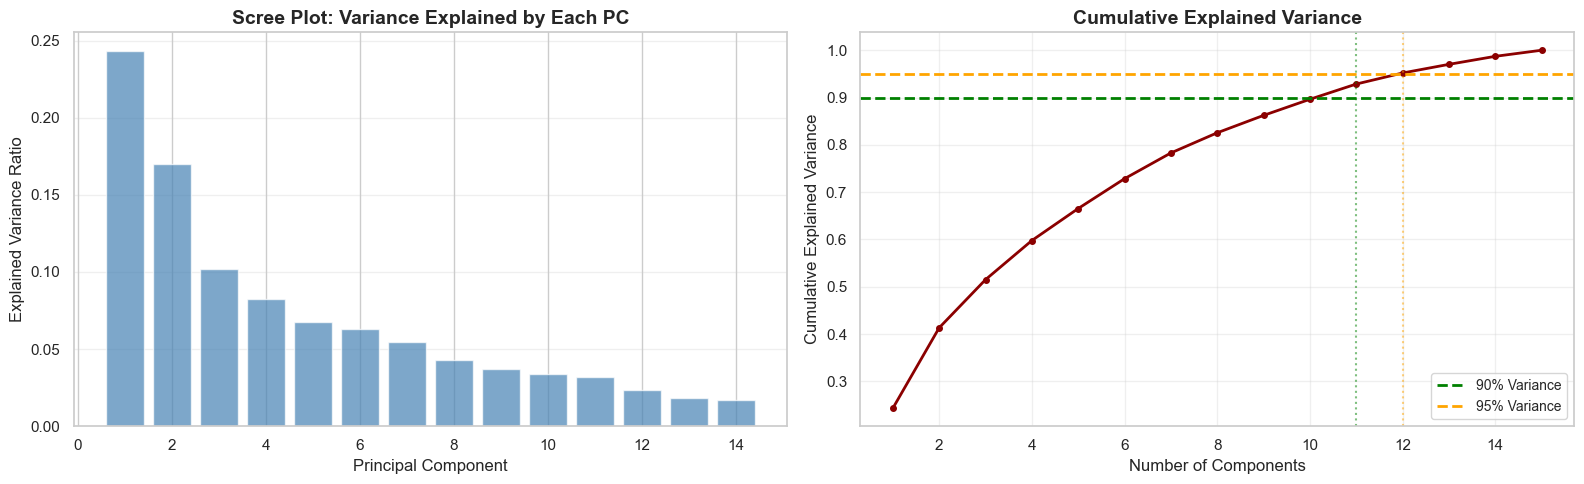

In [82]:
# 2. PCA ANALYSIS WITH EXPLAINED VARIANCE
from sklearn.decomposition import PCA

print("PCA ANALYSIS ON SCALED NUMERICAL FEATURES")

# Perform PCA on scaled data
pca = PCA()

X_pca = pca.fit_transform(X_viz)

# Calculate cumulative variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"\nExplained Variance by Component:")
for i, var in enumerate(pca.explained_variance_ratio_[:10], 1):
    cum_var = cumulative_variance[i-1]
    print(f"  PC{i}: {var:.4f} ({var*100:.2f}%) | Cumulative: {cum_var*100:.2f}%")

print(f"\nComponents needed for 90% variance: {n_components_90}")
print(f"Components needed for 95% variance: {n_components_95}")

# Visualization 1: Scree Plot & Cumulative Variance
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Scree plot
axes[0].bar(range(1, min(15, len(pca.explained_variance_ratio_)+1)),
            pca.explained_variance_ratio_[:14],
            alpha=0.7, color='steelblue')
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('Scree Plot: Variance Explained by Each PC', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Cumulative variance
axes[1].plot(range(1, len(cumulative_variance)+1),
             cumulative_variance,
             marker='o', linewidth=2, color='darkred', markersize=4)
axes[1].axhline(y=0.90, color='green', linestyle='--', label='90% Variance', linewidth=2)
axes[1].axhline(y=0.95, color='orange', linestyle='--', label='95% Variance', linewidth=2)
axes[1].axvline(x=n_components_90, color='green', linestyle=':', alpha=0.5)
axes[1].axvline(x=n_components_95, color='orange', linestyle=':', alpha=0.5)
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

PCA BIPLOT - CLUSTERS IN REDUCED SPACE


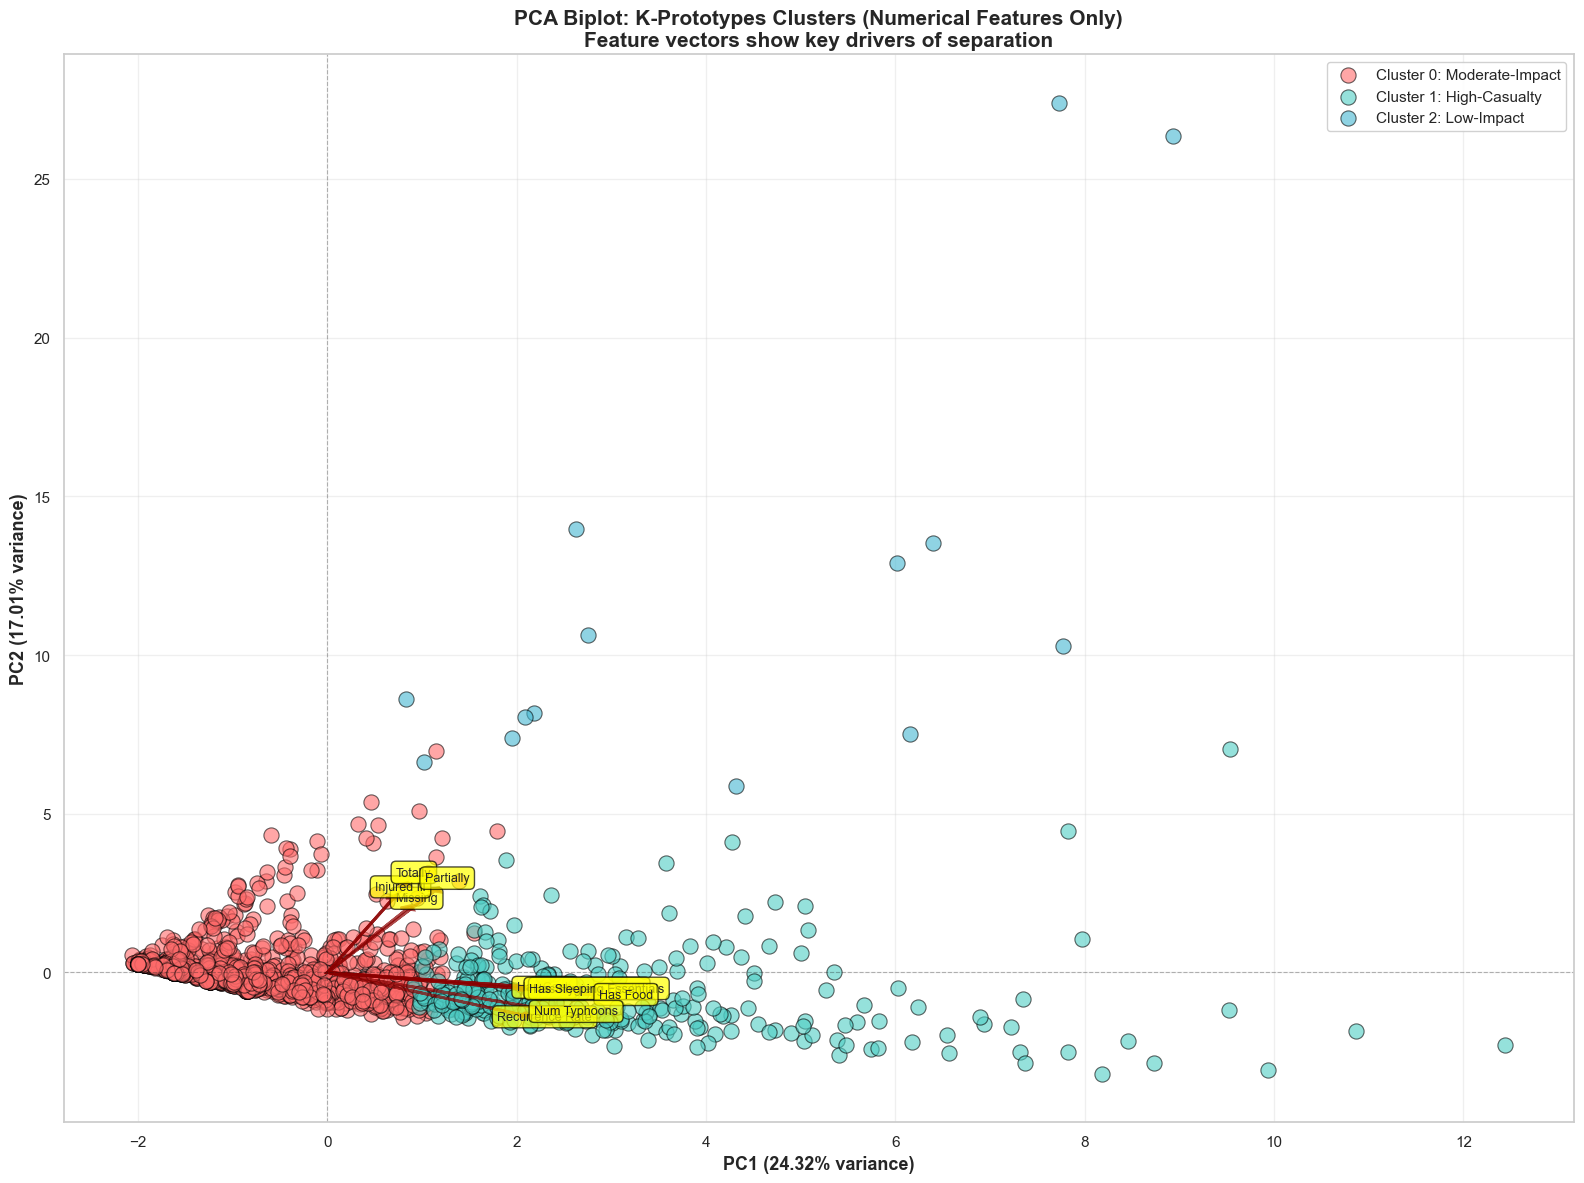

In [83]:
# 3. PCA BIPLOT (PC1 vs PC2) WITH FEATURE LOADINGS

print("PCA BIPLOT - CLUSTERS IN REDUCED SPACE")

# Create PCA DataFrame
pca_df = pd.DataFrame(
    X_pca[:, :3],
    columns=['PC1', 'PC2', 'PC3']
)
pca_df['cluster'] = clusters.values
pca_df['province'] = province_names

# Define cluster colors and labels
cluster_colors = {0: '#FF6B6B', 1: '#4ECDC4', 2: '#45B7D1'}
cluster_labels = {
    0: "Moderate-Impact",
    1: "High-Casualty",
    2: "Low-Impact"
}

# Get feature loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig, ax = plt.subplots(figsize=(16, 12))

# Plot points colored by cluster
for cluster_id in sorted(pca_df['cluster'].unique()):
    cluster_data = pca_df[pca_df['cluster'] == cluster_id]
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'],
               c=cluster_colors.get(cluster_id, 'gray'),
               label=f'Cluster {cluster_id}: {cluster_labels.get(cluster_id, "Unknown")}',
               alpha=0.6,
               s=120,
               edgecolors='black',
               linewidth=0.8)

# Add feature vectors (top 10 most influential)
# Calculate influence as sum of absolute loadings on PC1 and PC2
feature_influence = np.abs(loadings[:, 0]) + np.abs(loadings[:, 1])
top_features_idx = np.argsort(feature_influence)[-10:]

scale_factor = 3.5
for idx in top_features_idx:
    feature = numeric_features[idx]
    ax.arrow(0, 0,
             loadings[idx, 0] * scale_factor,
             loadings[idx, 1] * scale_factor,
             head_width=0.15, head_length=0.12,
             fc='darkred', ec='darkred', alpha=0.7, linewidth=2)

    # Clean feature names for display
    display_name = feature.replace('_sum', '').replace('_', ' ').title()
    ax.text(loadings[idx, 0] * scale_factor * 1.12,
            loadings[idx, 1] * scale_factor * 1.12,
            display_name,
            fontsize=9,
            ha='center',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.7, edgecolor='black'))

# Labels and legend
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)', fontsize=13, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)', fontsize=13, fontweight='bold')
ax.set_title('PCA Biplot: K-Prototypes Clusters (Numerical Features Only)\nFeature vectors show key drivers of separation',
             fontsize=15, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend(fontsize=11, loc='best', framealpha=0.9)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
ax.axvline(x=0, color='k', linestyle='--', alpha=0.3, linewidth=0.8)

plt.tight_layout()
plt.show()

In [84]:
# 4. 3D PCA VISUALIZATION (Interactive)

print("3D PCA VISUALIZATION")

# Add cluster labels for hover
pca_df['cluster_label'] = pca_df['cluster'].map(cluster_labels)

fig = px.scatter_3d(
    pca_df,
    x='PC1', y='PC2', z='PC3',
    color='cluster',
    hover_name='province',
    hover_data={'cluster_label': True, 'cluster': False},
    color_discrete_map=cluster_colors,
    title=f'3D PCA: K-Prototypes Clusters (Explains {cumulative_variance[2]*100:.1f}% variance)',
    labels={
        'PC1': f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)',
        'PC2': f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)',
        'PC3': f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)',
        'cluster': 'Cluster ID'
    }
)
fig.update_traces(marker=dict(size=6, line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(height=700)
fig.show()

3D PCA VISUALIZATION


t-SNE VISUALIZATION (Non-linear dimensionality reduction)


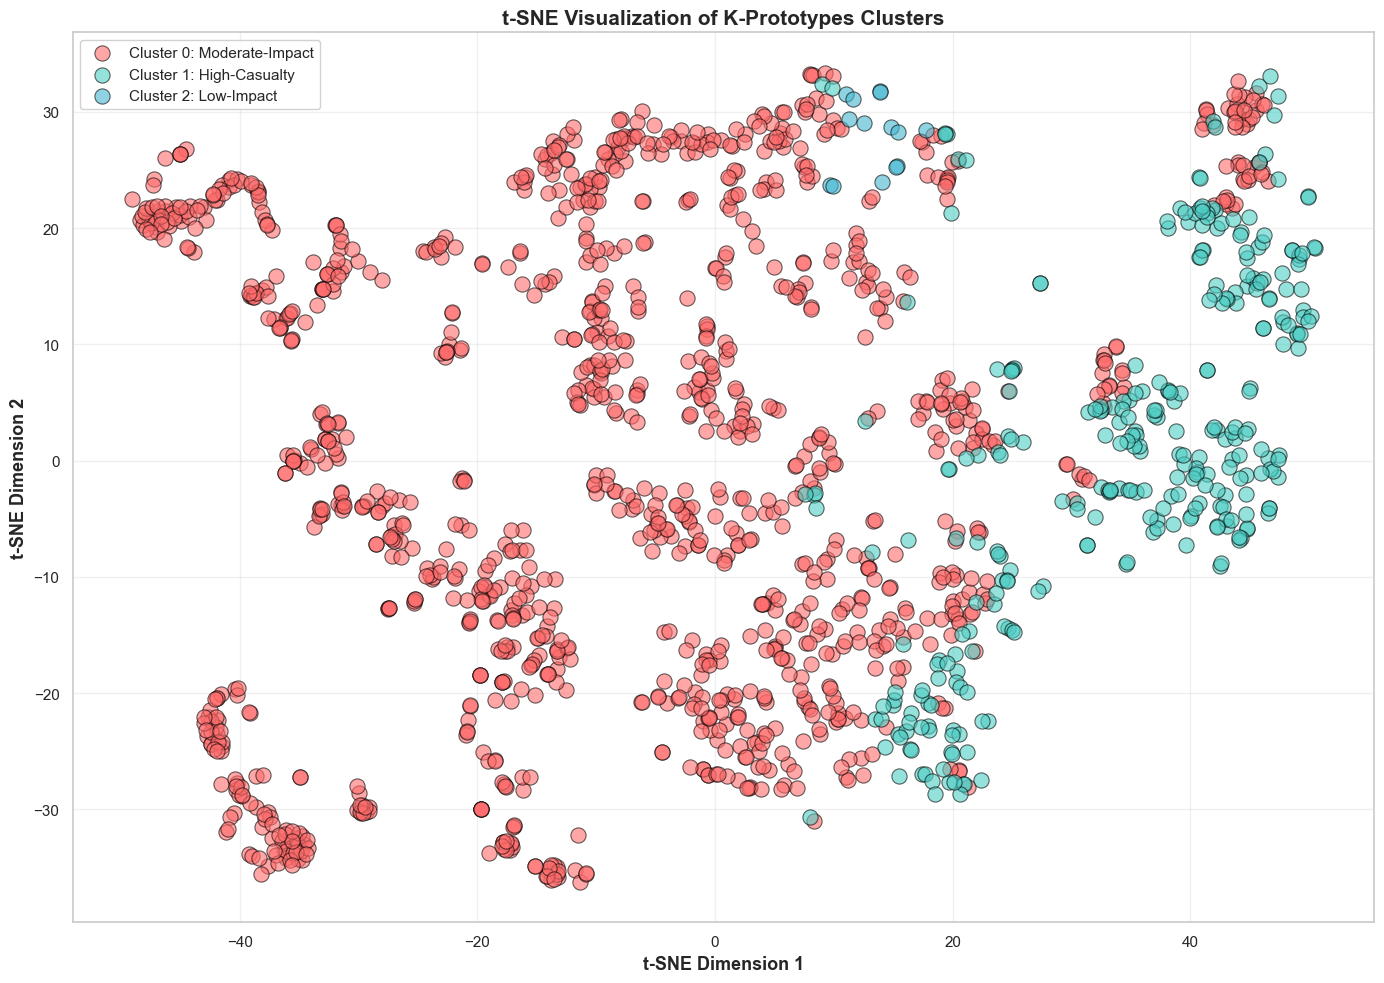

In [85]:
# 5. t-SNE VISUALIZATION

print("t-SNE VISUALIZATION (Non-linear dimensionality reduction)")

perplexity_val = min(30, len(X_viz) - 1)
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_val, n_iter=1000)
X_tsne = tsne.fit_transform(X_viz)

tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['cluster'] = clusters.values
tsne_df['province'] = province_names

fig, ax = plt.subplots(figsize=(14, 10))

for cluster_id in sorted(tsne_df['cluster'].unique()):
    cluster_data = tsne_df[tsne_df['cluster'] == cluster_id]
    ax.scatter(cluster_data['TSNE1'], cluster_data['TSNE2'],
               c=cluster_colors.get(cluster_id, 'gray'),
               label=f'Cluster {cluster_id}: {cluster_labels.get(cluster_id, "Unknown")}',
               alpha=0.6,
               s=120,
               edgecolors='black',
               linewidth=0.8)

ax.set_xlabel('t-SNE Dimension 1', fontsize=13, fontweight='bold')
ax.set_ylabel('t-SNE Dimension 2', fontsize=13, fontweight='bold')
ax.set_title('t-SNE Visualization of K-Prototypes Clusters', fontsize=15, fontweight='bold')
ax.legend(fontsize=11, loc='best', framealpha=0.9)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

FEATURE CONTRIBUTION TO PRINCIPAL COMPONENTS


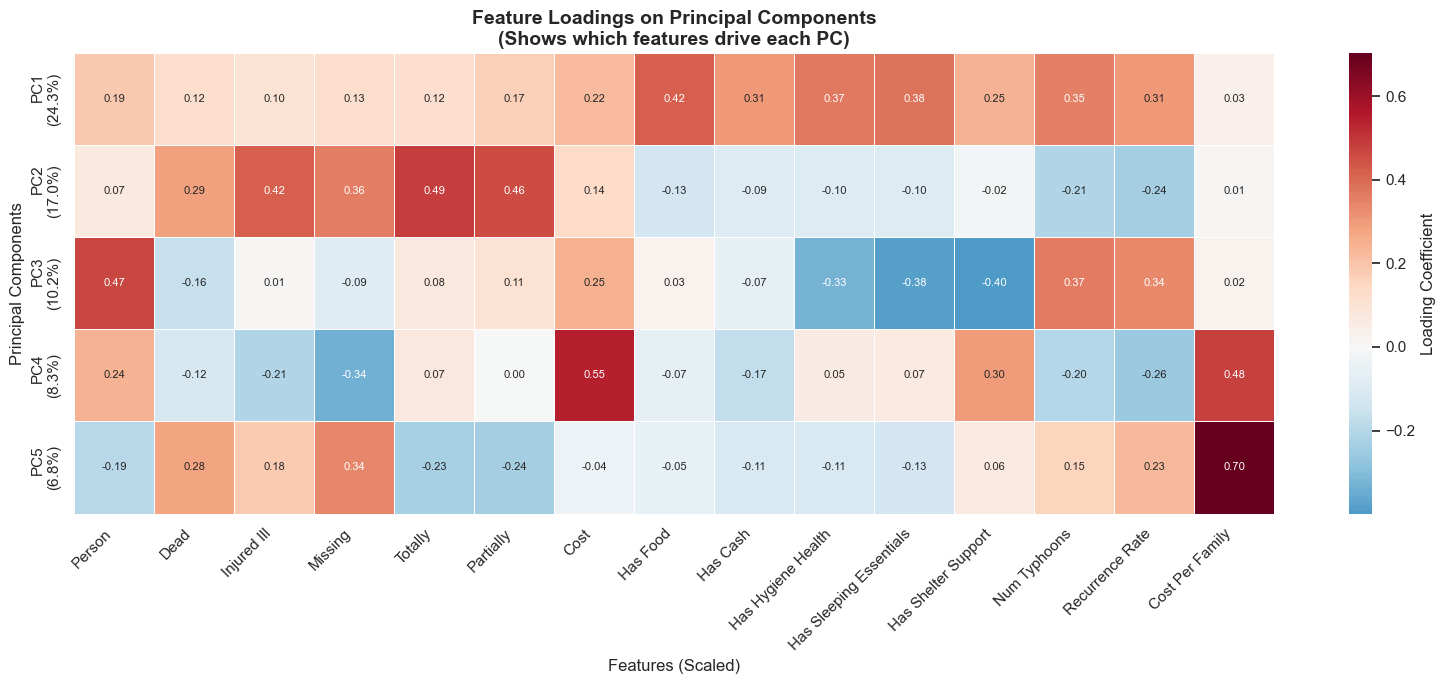

In [86]:
# 6. COMPONENT CONTRIBUTION HEATMAP

print("FEATURE CONTRIBUTION TO PRINCIPAL COMPONENTS")

# Get top N components
n_top_components = min(5, len(pca.components_))
loading_matrix = pd.DataFrame(
    pca.components_[:n_top_components, :],
    columns=[f.replace('_sum', '').replace('_', ' ').title() for f in numeric_features],
    index=[f'PC{i+1}\n({pca.explained_variance_ratio_[i]*100:.1f}%)' for i in range(n_top_components)]
)

plt.figure(figsize=(16, 7))
sns.heatmap(loading_matrix, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, linewidths=0.5, cbar_kws={'label': 'Loading Coefficient'},
            annot_kws={'size': 8})
plt.title('Feature Loadings on Principal Components\n(Shows which features drive each PC)',
          fontsize=14, fontweight='bold')
plt.xlabel('Features (Scaled)', fontsize=12)
plt.ylabel('Principal Components', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [87]:
# 7. VARIANCE EXPLAINED TABLE & TOP FEATURE CONTRIBUTORS

variance_table = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(min(10, len(pca.explained_variance_ratio_)))],
    'Variance Explained': pca.explained_variance_ratio_[:10],
    'Cumulative Variance': cumulative_variance[:10]
})

print("\n" + "="*60)
print("VARIANCE EXPLAINED SUMMARY")
print("="*60)
print(variance_table.to_string(index=False, float_format='%.4f'))

# Show top contributors to first 3 PCs
print("\n" + "="*60)
print("TOP FEATURE CONTRIBUTORS PER COMPONENT")
print("="*60)

for pc_idx in range(min(3, len(pca.components_))):
    print(f"\nPC{pc_idx+1} (Explains {pca.explained_variance_ratio_[pc_idx]*100:.2f}% variance):")
    component_loadings = pd.DataFrame({
        'Feature': numeric_features,
        'Loading': pca.components_[pc_idx, :]
    }).sort_values('Loading', key=abs, ascending=False)

    print("  Top 5 positive contributors:")
    for _, row in component_loadings.head(5).iterrows():
        print(f"    {row['Feature']:.<40} {row['Loading']:>7.3f}")



print("\n" + "="*60)
print("VISUALIZATION COMPLETE")
print("="*60)
print("\nNote: K-Prototypes uses both numerical AND categorical features")
print("for clustering, but PCA/t-SNE only visualize numerical features.")
print("The 'region' categorical variable influences cluster assignment")
print("but is not shown in these projections.")


VARIANCE EXPLAINED SUMMARY
Component  Variance Explained  Cumulative Variance
      PC1              0.2432               0.2432
      PC2              0.1701               0.4133
      PC3              0.1018               0.5150
      PC4              0.0827               0.5977
      PC5              0.0677               0.6654
      PC6              0.0631               0.7284
      PC7              0.0544               0.7828
      PC8              0.0426               0.8255
      PC9              0.0368               0.8622
     PC10              0.0341               0.8963

TOP FEATURE CONTRIBUTORS PER COMPONENT

PC1 (Explains 24.32% variance):
  Top 5 positive contributors:
    has_food_sum............................   0.421
    has_sleeping_essentials_sum.............   0.380
    has_hygiene_health_sum..................   0.369
    num_typhoons............................   0.351
    recurrence_rate.........................   0.307

PC2 (Explains 17.01% variance):
  Top 5 p

### MAACLI Framework

In [88]:
print(final_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1581 entries, ABORLAN - PALAWAN (4B) to ZUMARRAGA - SAMAR (8)
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   province_                    1581 non-null   object 
 1   region_                      1581 non-null   object 
 2   person_sum                   1581 non-null   float64
 3   dead_sum                     1581 non-null   float64
 4   injured_ill_sum              1581 non-null   float64
 5   missing_sum                  1581 non-null   float64
 6   totally_sum                  1581 non-null   float64
 7   partially_sum                1581 non-null   float64
 8   cost_sum                     1581 non-null   float64
 9   has_food_sum                 1581 non-null   int64  
 10  has_cash_sum                 1581 non-null   int64  
 11  has_hygiene_health_sum       1581 non-null   int64  
 12  has_sleeping_essentials_sum  1581 non-null 

In [ ]:
# --- Clean column names and ensure categorical consistency ---
final_df.columns = final_df.columns.str.strip()
final_df['region_'] = final_df['region_'].astype(str)
final_df['province_'] = final_df['province_'].astype(str)

# For city-level data, you may have columns like:
# "city_province_region" or "province_" or both.
# Keep 'region_' and optionally 'province_' if relevant for interpretation.

categorical_cols = ['region_', 'province_']
numeric_cols = [
    col for col in final_df.columns
    if col not in categorical_cols + ['city_province_region', 'cluster']
]

# --- Encode categorical for ML ---
df_encoded = final_df.copy()
for col in categorical_cols:
    df_encoded[col] = df_encoded[col].astype("category").cat.codes

X = df_encoded[numeric_cols + categorical_cols]
y = df_encoded['cluster']

# --- Train XGBoost Model ---
xgb = XGBClassifier(
    max_depth=4,
    learning_rate=0.1,
    n_estimators=200,
    random_state=42
)
xgb.fit(X, y)

# --- Feature Importances ---
print("Feature Importances:", xgb.feature_importances_)

perm_importance = permutation_importance(
    xgb, X, y,
    n_repeats=10,
    random_state=42,
    scoring='accuracy'
)

importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': perm_importance.importances_mean
}).sort_values('importance', ascending=False)

print("\n=== GLOBAL FEATURE IMPORTANCE ===")
print(importance_df)

Feature Importances: [0.02724564 0.04031036 0.01052337 0.00834128 0.03018945 0.00776957
 0.02265562 0.27815217 0.0594461  0.09152084 0.29818448 0.0280955
 0.04468681 0.03403611 0.00756276 0.00530706 0.00597287]

=== GLOBAL FEATURE IMPORTANCE ===
                        feature  importance
7                  has_food_sum    0.053700
10  has_sleeping_essentials_sum    0.048071
9        has_hygiene_health_sum    0.030614
8                  has_cash_sum    0.027198
13              recurrence_rate    0.023529
12                 num_typhoons    0.020557
11      has_shelter_support_sum    0.012144
0                    person_sum    0.010373
4                   totally_sum    0.007021
1                      dead_sum    0.005946
6                      cost_sum    0.004364
3                   missing_sum    0.000633
5                 partially_sum    0.000190
2               injured_ill_sum    0.000000
14              cost_per_family    0.000000
15                      region_    0.000000
16    

In [90]:
# Encode categorical again for decision tree
df_explain = final_df.copy()
df_explain['region_'] = df_explain['region_'].astype('category').cat.codes
df_explain['province_'] = df_explain['province_'].astype('category').cat.codes

X_tree = df_explain.drop(columns=['city_province_region', 'province_', 'cluster'], errors='ignore')
y_tree = df_explain['cluster']

tree = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=5,
    random_state=42
)
tree.fit(X_tree, y_tree)

rules = export_text(tree, feature_names=list(X_tree.columns))
print("=== DECISION TREE RULES ===")
print(rules)

=== DECISION TREE RULES ===
|--- has_sleeping_essentials_sum <= 0.50
|   |--- has_food_sum <= 3.50
|   |   |--- has_cash_sum <= 1.50
|   |   |   |--- person_sum <= 158360.00
|   |   |   |   |--- class: 0
|   |   |   |--- person_sum >  158360.00
|   |   |   |   |--- class: 0
|   |   |--- has_cash_sum >  1.50
|   |   |   |--- num_typhoons <= 15.50
|   |   |   |   |--- class: 0
|   |   |   |--- num_typhoons >  15.50
|   |   |   |   |--- class: 1
|   |--- has_food_sum >  3.50
|   |   |--- recurrence_rate <= 2.71
|   |   |   |--- has_food_sum <= 4.50
|   |   |   |   |--- class: 0
|   |   |   |--- has_food_sum >  4.50
|   |   |   |   |--- class: 1
|   |   |--- recurrence_rate >  2.71
|   |   |   |--- partially_sum <= 9035.50
|   |   |   |   |--- class: 1
|   |   |   |--- partially_sum >  9035.50
|   |   |   |   |--- class: 1
|--- has_sleeping_essentials_sum >  0.50
|   |--- has_food_sum <= 1.50
|   |   |--- num_typhoons <= 13.50
|   |   |   |--- has_cash_sum <= 0.50
|   |   |   |   |--- clas

In [ ]:
extra_features = [
    'has_hygiene_health_sum',
    'has_sleeping_essentials_sum',
    'has_shelter_support_sum',
    'recurrence_rate', 
    'cost_per_family'
]

cluster_labels = {
    0: "Moderate-Impact Typhoon-Affected Cities",
    1: "High-Casualty Typhoon-Affected Cities",
    2: "Low-Impact Typhoon-Affected Cities"
}

def describe_cluster(df, cluster_id, important_features, top_k=3):
    subset = df[df['cluster'] == cluster_id]
    desc = f"**Cluster {cluster_id} – {cluster_labels.get(cluster_id, 'Unlabeled')}**\n"

    # Combine top features and extras, ensuring uniqueness
    features_to_describe = list(dict.fromkeys(important_features[:top_k] + extra_features))

    for feat in features_to_describe:
        if feat in df.columns:
            if df[feat].dtype in ['object', 'category']:
                mode_val = subset[feat].mode().iloc[0] if not subset[feat].mode().empty else "N/A"
                desc += f"- {feat}: mostly '{mode_val}'\n"
            else:
                q1 = subset[feat].quantile(0.25)
                q3 = subset[feat].quantile(0.75)
                desc += f"- {feat}: 75% between {q1:,.0f} and {q3:,.0f}\n"
    return desc

# Exclude unimportant features
top_features = [
    f for f in importance_df['feature'].tolist()]


# --- Print cluster descriptions ---
for cluster_id in sorted(final_df['cluster'].unique()):
    print(describe_cluster(final_df, cluster_id, top_features, top_k=3))

**Cluster 0 – Moderate-Impact Typhoon-Affected Cities**
- has_food_sum: 75% between 0 and 1
- has_sleeping_essentials_sum: 75% between 0 and 0
- has_hygiene_health_sum: 75% between 0 and 0
- has_shelter_support_sum: 75% between 0 and 0
- recurrence_rate: 75% between 1 and 2

**Cluster 1 – High-Casualty Typhoon-Affected Cities**
- has_food_sum: 75% between 3 and 5
- has_sleeping_essentials_sum: 75% between 0 and 1
- has_hygiene_health_sum: 75% between 0 and 1
- has_shelter_support_sum: 75% between 0 and 1
- recurrence_rate: 75% between 2 and 4

**Cluster 2 – Low-Impact Typhoon-Affected Cities**
- has_food_sum: 75% between 1 and 2
- has_sleeping_essentials_sum: 75% between 0 and 1
- has_hygiene_health_sum: 75% between 0 and 1
- has_shelter_support_sum: 75% between 0 and 0
- recurrence_rate: 75% between 1 and 2



In [92]:
final_df.columns

Index(['province_', 'region_', 'person_sum', 'dead_sum', 'injured_ill_sum',
       'missing_sum', 'totally_sum', 'partially_sum', 'cost_sum',
       'has_food_sum', 'has_cash_sum', 'has_hygiene_health_sum',
       'has_sleeping_essentials_sum', 'has_shelter_support_sum',
       'num_typhoons', 'recurrence_rate', 'cost_per_family', 'cluster'],
      dtype='object')

In [93]:
with open('cluster_explanations_MAACLI.txt', 'w') as f:
    f.write("=== MAACLI CLUSTER EXPLANATIONS ===\n\n")
    f.write("1. DECISION TREE RULES:\n")
    f.write(rules)
    f.write("\n2. CLUSTER DESCRIPTIONS:\n")
    for c in sorted(final_df['cluster'].unique()):
        f.write(describe_cluster(final_df, c, top_features))

Cluster 0 – Moderate-Impact Typhoons Cyclones

This cluster represents Typhoons Cyclones with moderate disaster costs, moderate food and relief distribution, and intermediate mortality levels. Affected provinces typically receive sustained support in hygiene, sleeping essentials, and shelter assistance, indicating significant but manageable relief operations. The recurrence rate of 4–5 events per year suggests these provinces are consistently exposed, requiring repeated preparedness and recovery cycles.

Cluster 1 – High-Casualty Typhoons Cyclones

This cluster is defined primarily by elevated death counts, despite moderate costs and limited relief distribution (food, hygiene, sleeping, shelter). The relatively low recurrence rate (2–3 events/year) suggests that although provinces here experience fewer Typhoons Cyclones, when disasters occur, they tend to be extremely lethal. This highlights cases of extreme vulnerability, insufficient preparedness, or unusually severe Typhoons Cyclones that overwhelm existing response capacity.

Cluster 2 – Low-Impact Typhoons Cyclones

This cluster contains Typhoons Cyclones with minimal economic costs, negligible mortality, and limited relief needs (very low hygiene, shelter, and sleeping support). The recurrence rate (2–4 events/year) indicates that these provinces are regularly affected, but the impacts remain low in severity, possibly due to weaker storm intensities or effective local mitigation and adaptation measures.